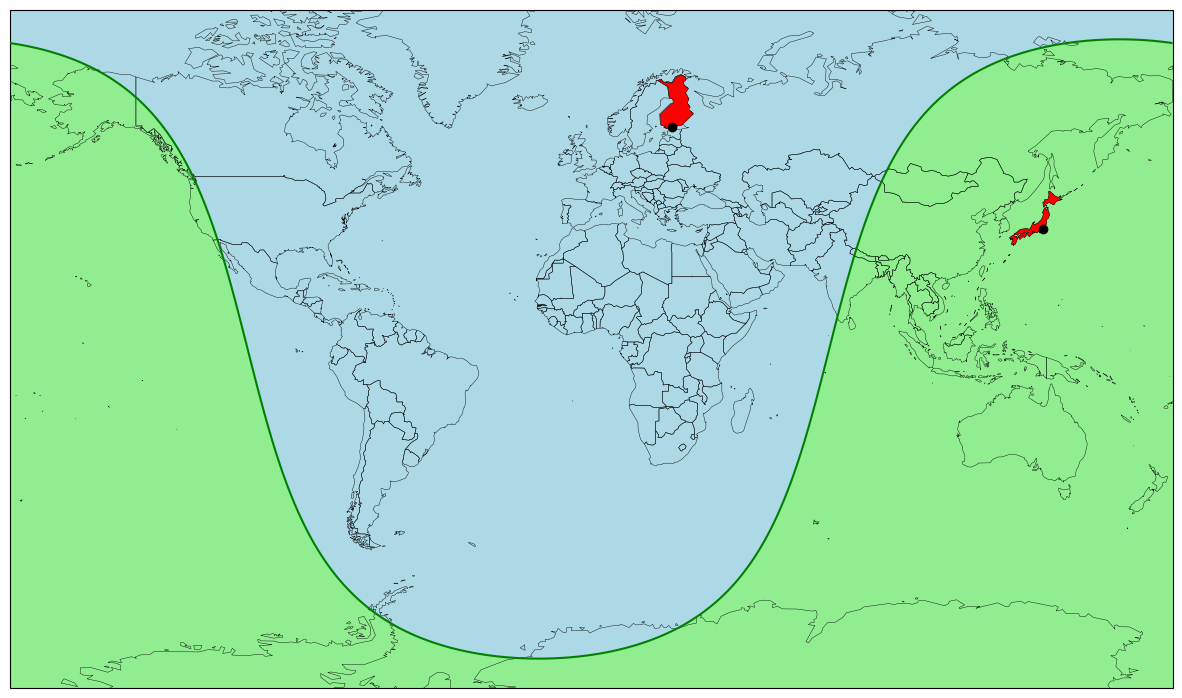

In [1]:
# 球面两点的球面中垂线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic

# 读取地图数据
world = gpd.read_file('./worldmap4/world.json')

# 设置投影
world = world.to_crs(ccrs.PlateCarree())

# 选取目标点所属国家
c1 = world[world['name'] == '芬兰']
c2 = world[world['name'] == '日本']

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})

# 绘制世界地图
world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=1)

# 将目标点所属国家填充为红色
c1.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)
c2.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)

# 设置两个目标点
lat1, lon1 = 60.17104926742669, 24.93805711554702
lat2, lon2 = 35.680880043438144, 139.77022963207594
# 生成经纬度网格
lats = np.linspace(-90, 90, 300)
lons = np.linspace(-180, 180, 600)
lon_grid, lat_grid = np.meshgrid(lons, lats)
distance_diff = np.zeros(lon_grid.shape)

# 计算每个网格点到目标点的球面距离
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        point = (lat_grid[i, j], lon_grid[i, j])
        d1 = geodesic(point, (lat1, lon1)).kilometers
        d2 = geodesic(point, (lat2, lon2)).kilometers
        distance_diff[i, j] = d1 - d2

# 绘制填充等高线，等价于填充分界线两侧颜色
contourf = ax.contourf(lon_grid, lat_grid, distance_diff, levels=[-1e10, 0, 1e10], colors=['lightblue', 'lightgreen'], transform=ccrs.PlateCarree(), zorder=0)

# 绘制等高线，等价于绘制平分线
contour = ax.contour(lon_grid, lat_grid, distance_diff, levels=[0], colors='green', transform=ccrs.PlateCarree(), zorder=3)

# 绘制目标点
ax.scatter([lon1, lon2], [lat1, lat2], color='black', marker='o', transform=ccrs.PlateCarree(), zorder=4)

# 设置横纵坐标刻度不可见
ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# 设置地图显示范围
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())

# 保存图像并显示
# plt.savefig('output6.png', dpi=300, bbox_inches='tight')
plt.show()


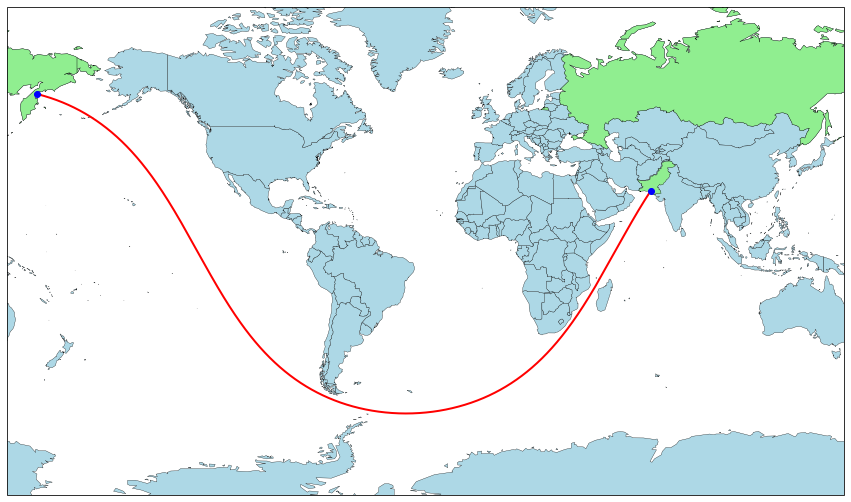

In [8]:
#球面两点的较长大地线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Geod

# 读取世界地图数据
world = gpd.read_file('world.zh.json')
world = world.to_crs(ccrs.PlateCarree())

# 提取俄罗斯和巴基斯坦的数据
c1 = world[world['name'] == '俄罗斯']
c2 = world[world['name'] == '巴基斯坦']

# prepare points
# P1
lat1, lon1 = 59.18232447782983, 162.90673502275226
# P1's antipode
lat1a = -lat1
lon1a = lon1 - 180
# p2
lat2, lon2 = 25.174689841781433, 66.75388912356865
# P2's antipode
lat2a = -lat2
lon2a = lon2 - 180


# 创建图形和投影
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=-30)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c1.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c2.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# 使用 pyproj 的 Geod 计算大圆弧线
geod = Geod(ellps="WGS84")

# Geodetic lines: P2-P1_antipode
num_points = 200
point1 = geod.npts(lon2, lat2, lon1a, lat1a, num_points)
# Geodetic lines: P1_antipode-P2_antipode
point2 = geod.npts(lon1a, lat1a, lon2a, lat2a, num_points)
# Geodetic lines: P2_antipode-P1
point3 = geod.npts(lon2a, lat2a, lon1, lat1, num_points)
points = point1 + point2 + point3

# 提取较长的一段路径
lons, lats = zip(*points)
# 绘制较长的大圆弧线
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.Geodetic())

# 在地图上标记特定的经纬度点
ax.scatter([lon1, lon2], [lat1, lat2], color='b', marker='o', zorder=5, transform=ccrs.PlateCarree())

# 设置图形的外观和保存图像
ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())
# plt.savefig('outputN.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# 读取美国各州的GeoJSON文件
world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())


# 创建图并添加节点和边
G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])

# 标记直接与海洋接壤的州（假设这些州已经预先定义）
ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii'
]

# 使用BFS计算每个州到达海洋的最小间隔州数
min_steps_to_ocean = {state: float('inf') for state in G.nodes}
print(min_steps_to_ocean)

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

# 打印结果
for state, steps in min_steps_to_ocean.items():
    print(f'{state}: {steps} steps to the nearest ocean')




{'Washington': inf, 'Idaho': inf, 'Oregon': inf, 'Montana': inf, 'Utah': inf, 'Wyoming': inf, 'Nevada': inf, 'North Dakota': inf, 'South Dakota': inf, 'Minnesota': inf, 'Michigan': inf, 'Iowa': inf, 'Wisconsin': inf, 'Ohio': inf, 'Illinois': inf, 'Indiana': inf, 'Pennsylvania': inf, 'Kentucky': inf, 'West Virginia': inf, 'New York': inf, 'Maryland': inf, 'Delaware': inf, 'New Jersey': inf, 'Vermont': inf, 'Connecticut': inf, 'Massachusetts': inf, 'New Hampshire': inf, 'Maine': inf, 'Arizona': inf, 'California': inf, 'New Mexico': inf, 'Colorado': inf, 'Texas': inf, 'Oklahoma': inf, 'Louisiana': inf, 'Arkansas': inf, 'Alaska': inf, 'Mississippi': inf, 'Alabama': inf, 'Tennessee': inf, 'Florida': inf, 'Georgia': inf, 'South Carolina': inf, 'North Carolina': inf, 'Virginia': inf, 'District of Columbia': inf, 'Rhode Island': inf, 'Hawaii': inf, 'Nebraska': inf, 'Kansas': inf, 'Missouri': inf}
Washington: 0 steps to the nearest ocean
Idaho: 1 steps to the nearest ocean
Oregon: 0 steps to th

In [26]:
import geopandas as gpd
import pandas as pd

province = gpd.read_file('./chinamap/province/test.json')
province.head(10)
province.to_csv('china_city2.csv', index=False, encoding='utf-8-sig')
# c1 = rivers[rivers['name_zh'] == '多瑙河']
# c1

(0.993248, 0.906157, 0.143936, 1.0)
['Washington', 'Oregon', 'New York', 'Maryland', 'Delaware', 'New Jersey', 'Connecticut', 'Massachusetts', 'New Hampshire', 'Maine', 'California', 'Texas', 'Louisiana', 'Alaska', 'Mississippi', 'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'Rhode Island', 'Hawaii']
(0.360741, 0.785964, 0.387814, 1.0)
['Idaho', 'Nevada', 'Pennsylvania', 'Kentucky', 'West Virginia', 'Vermont', 'Arizona', 'New Mexico', 'Oklahoma', 'Arkansas', 'Tennessee', 'District of Columbia']
(0.128729, 0.563265, 0.551229, 1.0)
['Montana', 'Utah', 'Wyoming', 'Ohio', 'Illinois', 'Indiana', 'Colorado', 'Kansas', 'Missouri']
(0.231674, 0.318106, 0.544834, 1.0)
['North Dakota', 'South Dakota', 'Michigan', 'Iowa', 'Wisconsin', 'Nebraska']
(0.267004, 0.004874, 0.329415, 1.0)
['Minnesota']


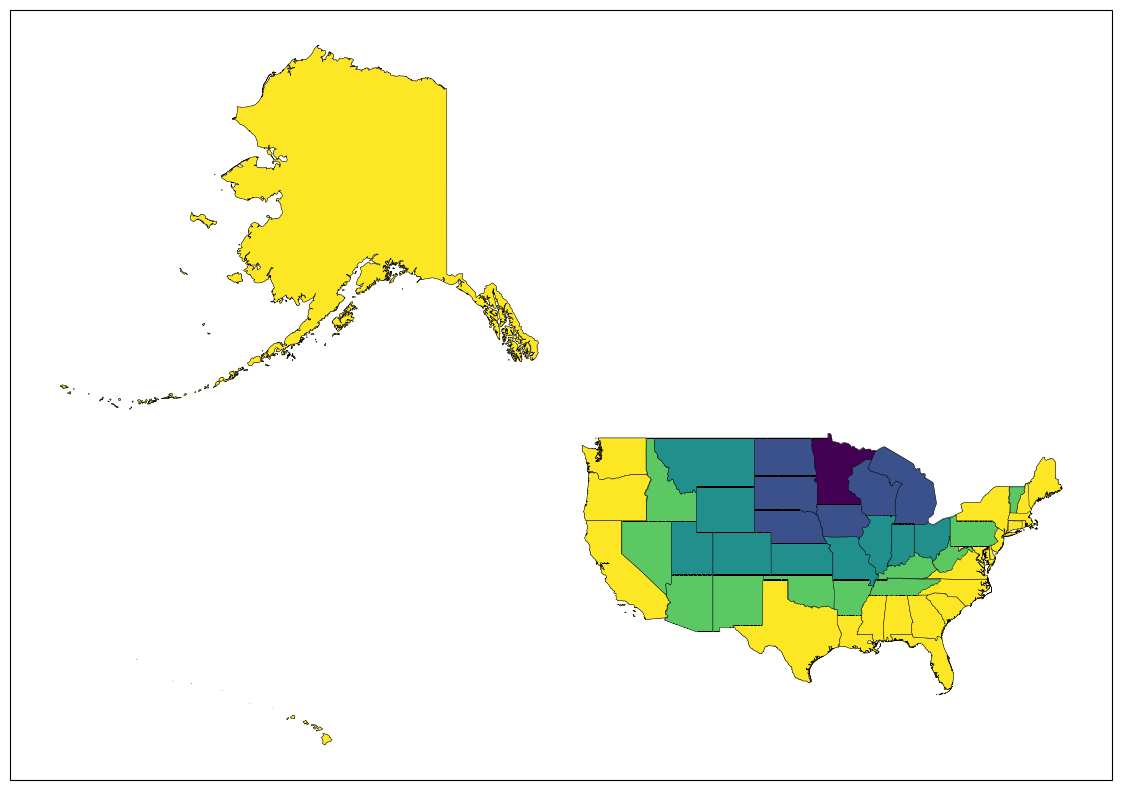

In [21]:
# 行政区分析

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
us.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii', 'Alaska'
]

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=stepMax)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, stepMax+1):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = us[us['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
 


ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# ax.set_extent([-25, 40, 33, 68], crs=ccrs.PlateCarree())
# plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()


(0.993248, 0.906157, 0.143936, 1.0)
['汕尾市', '漳州市', '揭阳市', '潮州市', '舟山市', '葫芦岛市', '秦皇岛市', '锦州市', '深圳市', '惠州市', '香港特别行政区', '东莞市', '泉州市', '福州市', '大连市', '丹东市', '营口市', '嘉兴市', '滨州市', '珠海市', '澳门特别行政区', '中山市', '江门市', '厦门市', '莆田市', '日照市', '潍坊市', '连云港市', '盘锦市', '唐山市', '天津市', '台州市', '盐城市', '南通市', '汕头市', '威海市', '烟台市', '宁波市', '阳江市', '茂名市', '广州市', '青岛市', '三亚市', '陵水黎族自治县', '乐东黎族自治县', '台湾省', '万宁市', '昌江黎族自治县', '东方市', '东营市', '沧州市', '儋州市', '临高县', '澄迈县', '海口市', '琼海市', '文昌市', '上海市', '宁德市', '温州市', '防城港市', '钦州市', '北海市', '三沙市', '湛江市']
(0.477504, 0.821444, 0.318195, 1.0)
['梅州市', '河源市', '龙岩市', '朝阳市', '承德市', '阜新市', '杭州市', '湖州市', '三明市', '南平市', '鞍山市', '梧州市', '清远市', '境界线', '徐州市', '保定市', '衡水市', '金华市', '丽水市', '济南市', '德州市', '淄博市', '临沂市', '崇左市', '南宁市', '沈阳市', '辽阳市', '韶关市', '绍兴市', '淮安市', '扬州市', '泰州市', '云浮市', '宿迁市', '佛山市', '本溪市', '保亭黎族苗族自治县', '贵港市', '玉林市', '琼中黎族苗族自治县', '五指山市', '白沙黎族自治县', '通化市', '屯昌县', '定安县', '苏州市', '北京市', '廊坊市']
(0.134692, 0.658636, 0.517649, 1.0)
['赣州市', '忻州市', '赤峰市', '通辽市', '菏泽市', '聊城市', '济宁市', '泰安市', '

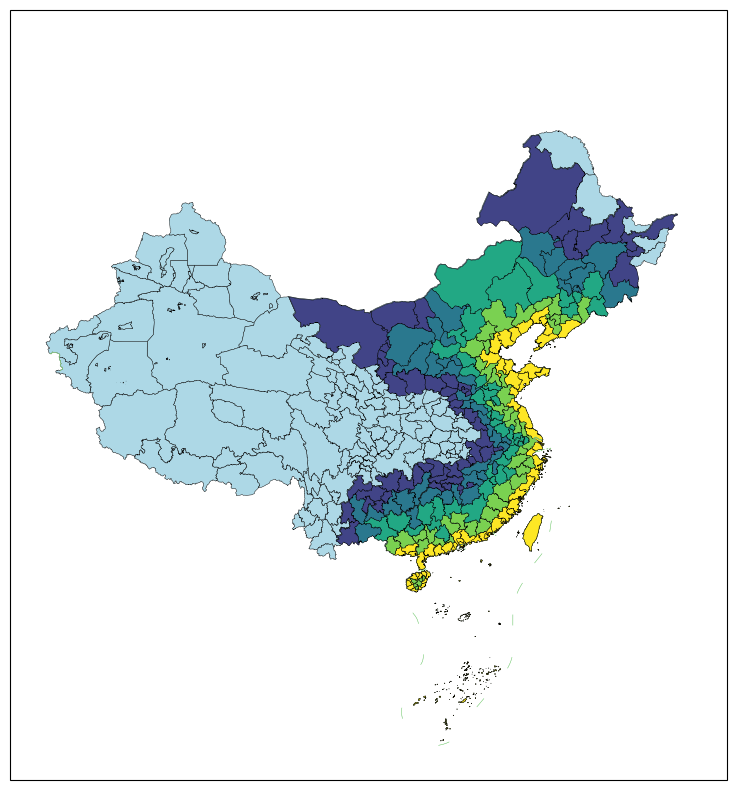

In [2]:
# 勘误：阳西县-阳江市，海丰县-汕尾市，揭阳县-揭阳市，市辖区(南通市)-
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


# 读取地图数据
# world = gpd.read_file('./chinamap/china_standard_shp/中国地州界.shp')
world = gpd.read_file('./shp2json/chinacity.geojson')
# china = gpd.read_file('./chinamap/geo_china.json')
# world = gpd.read_file('output.geojson')
world = world.to_crs(ccrs.PlateCarree())
# china = china.to_crs(ccrs.PlateCarree())


G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ['丹东市','大连市','营口市','盘锦市','锦州市','葫芦岛市','秦皇岛市','唐山市','天津市','沧州市','滨州市','东营市','潍坊市','烟台市',
                    '威海市','青岛市','日照市','连云港市','盐城市','南通市','上海市','嘉兴市','宁波市','舟山市','台州市','温州市','宁德市','福州市',
                    '莆田市','泉州市','厦门市','漳州市','潮州市','汕头市','揭阳市','汕尾市','惠州市','深圳市','东莞市','广州市','中山市','珠海市',
                    '江门市','阳江市','茂名市','湛江市','北海市','钦州市','防城港市','台湾省','香港特别行政区','澳门特别行政区','海口市','澄迈县',
                    '临高县','儋州市','昌江黎族自治县','东方市','乐东黎族自治县','三亚市','陵水黎族自治县','万宁市','琼海市','文昌市','三沙市']


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


for city in china_ocean_city:
    city_data = world[world['name'] == city]
    if not city_data.empty:
        city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=5)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 5):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# china.plot(ax=ax, color='None', edgecolor='red', linewidth=0.8, transform=ccrs.PlateCarree())



# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=400, bbox_inches='tight')
plt.show()


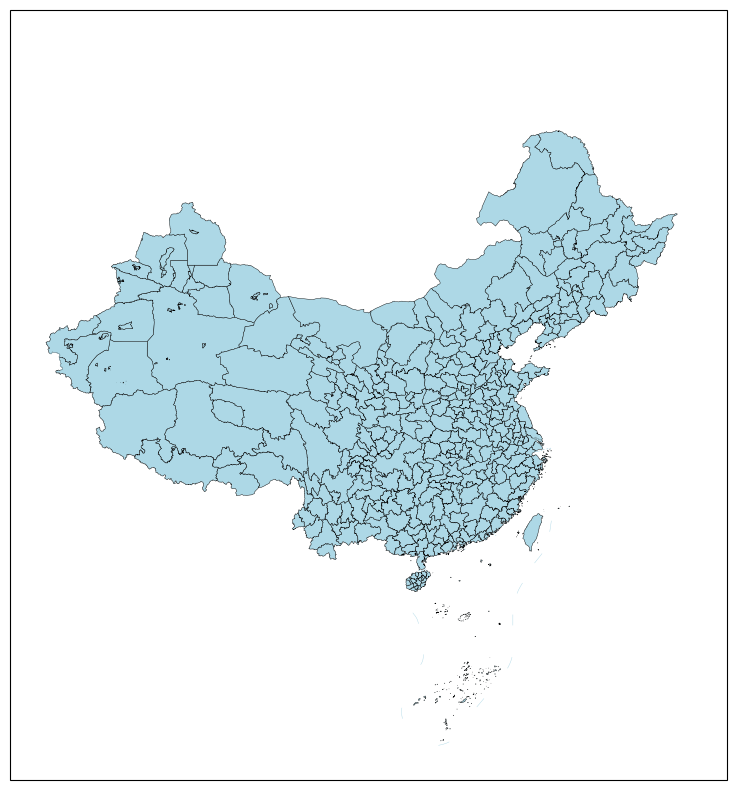

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

# 读取地图数据
# world = gpd.read_file('./chinamap/province/test.json')
# world = gpd.read_file('output.geojson')
world = gpd.read_file('./shp2json/chinacity.geojson')
world = world.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

plt.show()


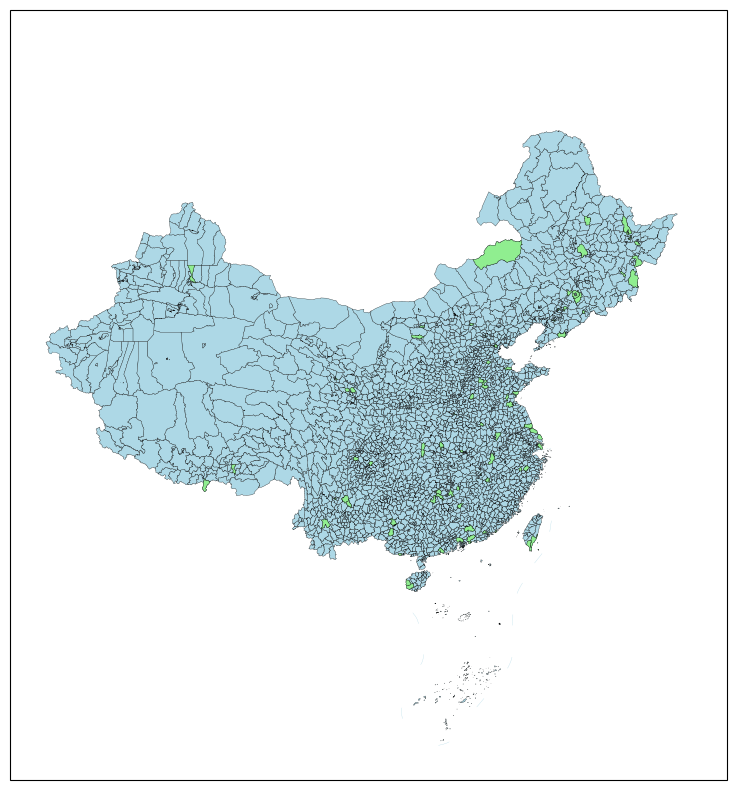

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

china_ocean_city = ['振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区','大洼区',
                    '兴隆台区','凌海市','太和区','连山区','龙港区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
                    '滦南区','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光市','寒亭区','昌邑市','莱州市',
                    '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区','市北区','市南区',
                    '李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
                    '海安市','如东县','通州区','海门区','启东市','崇明区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
                    '镇海区','北仑区','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
                    '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县','福鼎市','霞浦县','福安市','蕉城区','罗源县','连江县','马尾区','长乐区','福清市',
                    '平潭县','涵江区','荔城区','秀屿区','城厢区','仙游县','泉港区','惠安县','洛江区','丰泽区','晋江市','石狮市','南安市','翔安区','同安区','集美区',
                    '海沧区','龙海区','思明区','湖里区','金门县','漳浦县','云霄县','东山县','诏安县','饶平县','澄海区','南澳县','龙湖区','濠江区','金平区','榕城区',
                    '潮阳区','潮南区','惠来县','陆丰市','城区','海丰县','惠东县','惠阳区','龙岗区','盐田区','福田区','南山区','宝安区','东莞市','南沙区','中山市','香洲区',
                    '金湾区','斗门区','新会区','台山市','阳东区','江城区','阳西县','电白区','吴川市','坡头区','霞山区','麻章区','赤坎区','遂溪县','雷州市','徐闻县',
                    '廉江市','合浦县','铁山港区','银海区','海城区','钦南区','防城区','港口区','东兴市','文昌市','美兰区','龙华区','秀英区','澄迈县','临高县','儋州市',
                    '昌江黎族自治县','东方市','乐东黎族自治县','崖州区','天涯区','吉阳区','海棠区','陵水黎族自治县','万宁市','琼海市','西沙区','南沙区','基隆市','新北市',
                    '桃园市','新竹市','新竹县','苗栗县','台中市','彰化县','云林县','嘉义县','台南市','高雄市','屏东县','台东县','花莲县','宜兰县']

china = gpd.read_file('./shp2json/chinacounty.geojson')
china = china.to_crs(ccrs.PlateCarree())

# listCounty = china[(china['name'].isin(china_ocean_city))]
listCounty = china[(china['name'].str.contains('东'))]
listCounty = listCounty.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
china.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
listCounty.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())

legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightgreen', markersize=10, label='距离上海浦东机场场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightgreen', markersize=10, label='距离上海虹桥机场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightcoral', markersize=10, label='距离杭州萧山机场更近', linestyle='None'),
    Line2D([0], [0], marker='o', color='k', markerfacecolor='lightyellow', markersize=10, label='距离南京禄口机场更近', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize='large')
legend.get_frame().set_facecolor('lightgray')


# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())
# plt.savefig('chinacounty.png', dpi=800, bbox_inches='tight')
plt.show()


In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

china = gpd.read_file('./shp2json/countybyprovince/河北省_县.geojson')
china = china.to_crs(ccrs.PlateCarree())
list_county = china[china['name'].str.contains('[东南西北]', regex=True)]
print(len(list_county))




15


In [28]:
import geopandas as gpd
import cartopy.crs as ccrs
import os

# 目标目录路径
directory_path = './shp2json/countybyprovince'

# 存储每个文件的统计结果
file_counts = []

# 遍历目录中的所有 GeoJSON 文件
for filename in os.listdir(directory_path):
    if filename.endswith('.geojson'):
        file_path = os.path.join(directory_path, filename)
        
        # 读取 GeoJSON 文件
        china = gpd.read_file(file_path)
        china = china.to_crs(ccrs.PlateCarree())
        
        # 统计当前文件中东南西北的总出现次数
        list_county = china[china['name'].str.contains('[东南西北]', regex=True)]
        
        # 记录结果
        file_counts.append((filename, len(list_county)))

# 按照统计数字降序排列
file_counts.sort(key=lambda x: x[1], reverse=True)

# 格式化输出结果
file_counts_str = [f"{filename}: {count}" for filename, count in file_counts]
print("统计结果：")
print(", ".join(file_counts_str))


统计结果：
黑龙江省_县.geojson: 19, 广西壮族自治区_县.geojson: 18, 广东省_县.geojson: 16, 河北省_县.geojson: 15, 辽宁省_县.geojson: 15, 四川省_县.geojson: 13, 云南省_县.geojson: 12, 山东省_县.geojson: 12, 江西省_县.geojson: 11, 吉林省_县.geojson: 10, 河南省_县.geojson: 10, 湖南省_县.geojson: 10, 湖北省_县.geojson: 9, 天津市_县.geojson: 8, 安徽省_县.geojson: 8, 浙江省_县.geojson: 8, 甘肃省_县.geojson: 8, 重庆市_县.geojson: 7, 内蒙古自治区_县.geojson: 6, 江苏省_县.geojson: 6, 青海省_县.geojson: 5, 海南省_县.geojson: 4, 福建省_县.geojson: 4, 贵州省_县.geojson: 4, 陕西省_县.geojson: 4, 西藏自治区_县.geojson: 3, 北京市_县.geojson: 2, 宁夏回族自治区_县.geojson: 2, 新疆维吾尔自治区_县.geojson: 2, 上海市_县.geojson: 1, 山西省_县.geojson: 1, 台湾省_市.geojson: 0, 澳门特别行政区_省.geojson: 0, 香港特别行政区_市.geojson: 0


C:\Users\geste\AppData\Local\Temp\ipykernel_71652\2636889386.py:35: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  list4.plot(ax=ax, color='lightcoral', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())


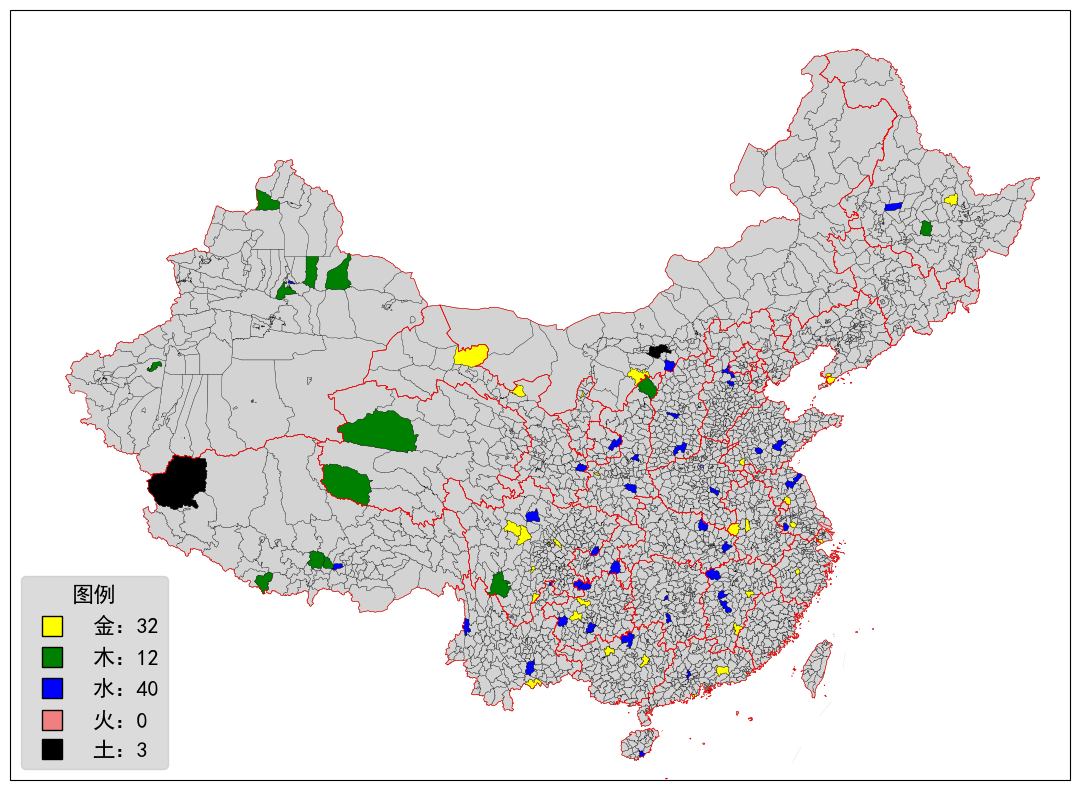

In [16]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def countUnit(china, key):
    listCounty = china[(china['name'].str.contains(key))]
    return listCounty, len(listCounty)

china = gpd.read_file('./shp2json/chinacounty.geojson')
china = china.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

list1, num1 = countUnit(china, '金')
list2, num2 = countUnit(china, '木')
list3, num3 = countUnit(china, '水')
list4, num4 = countUnit(china, '火')
list5, num5 = countUnit(china, '土')
list1 = list1.to_crs(ccrs.PlateCarree())
list2 = list2.to_crs(ccrs.PlateCarree())
list3 = list3.to_crs(ccrs.PlateCarree())
list4 = list4.to_crs(ccrs.PlateCarree())
list5 = list5.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
china.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list1.plot(ax=ax, color='yellow', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list2.plot(ax=ax, color='green', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list3.plot(ax=ax, color='blue', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list4.plot(ax=ax, color='lightcoral', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
list5.plot(ax=ax, color='black', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.4, transform=ccrs.PlateCarree())

jinshuiqu_data = china[china['name'] == '金水区']
if not jinshuiqu_data.empty:
    jinshuiqu_data.plot(
        ax=ax,
        facecolor='yellow',
        edgecolor='blue',
        linewidth=0.2,
        hatch='//////////',
        alpha=0.9,
        transform=ccrs.PlateCarree()
    )

legend_elements = [
    Line2D([0], [0], marker='s', color='k', markerfacecolor='yellow', markersize=14, label='金：' + str(num1), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='green', markersize=14, label='木：' + str(num2), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='blue', markersize=14, label='水：' + str(num3), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='lightcoral', markersize=14, label='火：' + str(num4), linestyle='None'),
    Line2D([0], [0], marker='s', color='k', markerfacecolor='black', markersize=14, label='土：' + str(num5), linestyle='None')
]

legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 16})
legend.get_frame().set_facecolor('lightgray')




# 设置地图显示范围
ax.set_extent([70, 137, 17, 55], crs=ccrs.PlateCarree())
plt.savefig('chinacounty4.png', dpi=800, bbox_inches='tight')
plt.show()


(0.993248, 0.906157, 0.143936, 1.0)
['龙华区', '宝安区', '东莞市', '盐田区', '龙岗区', '惠阳区', '河口瑶族自治县', '金平苗族瑶族傣族自治县', '马关县', '绿春县', '江城哈尼族彝族自治县', '大新县', '台山市', '阳东区', '新会区', '图们市', '珲春市', '穆棱市', '东宁市', '南山区', '福田区', '安图县', '和龙市', '龙井市', '抚松县', '北区', '元朗区', '滦南县', '乐亭县', '曹妃甸区', '丰南区', '昌黎县', '惠东县', '凭祥市', '龙州县', '宁明县', '富宁县', '靖西市', '滨海新区', '大丰区', '亭湖区', '东台市', '浪卡子县', '射阳县', '仙游县', '城厢区', '涵江区', '洛江区', '泉港区', '南安市', '那坡县', '连山区', '凌海市', '滨海县', '响水县', '灌云县', '荔城区', '秀屿区', '福清市', '南沙区(三沙)', '西沙区', '合浦县', '银海区', '海城区', '铁山港区', '钦南区', '廉江市', '达尔罕茂明安联合旗', '乌拉特中旗', '四子王旗', '伊州区', '沾化区', '利津县', '无棣县', '河口区', '长白朝鲜族自治县', '临江市', '绥滨县', '萝北县', '同江市', '嘉荫县', '寿光市', '贡山独龙族怒族自治县', '福贡县', '察隅县', '浑江区', '盖州市', '大洼区', '鲅鱼圈区', '西市区', '普兰店区', '庄河市', '瓦房店市', '防城区', '托里县', '和布克赛尔蒙古自治县', '白杨市', '塔城市', '伊吾县', '皮山县', '可克达拉市', '察布查尔锡伯自治县', '霍城县', '霍尔果斯市', '广饶县', '寒亭区', '昌邑市', '胶州市', '莱州市', '阿克陶县', '黄岛区', '博乐市', '阿拉山口市', '精河县', '福海县', '阿勒泰市', '黄骅市', '东营区', '肃北蒙古族自治县', '阿拉善右旗', '额济纳旗', '阿拉善左旗', '乌拉特后旗', '澜沧拉祜族自治县', '勐海县', 

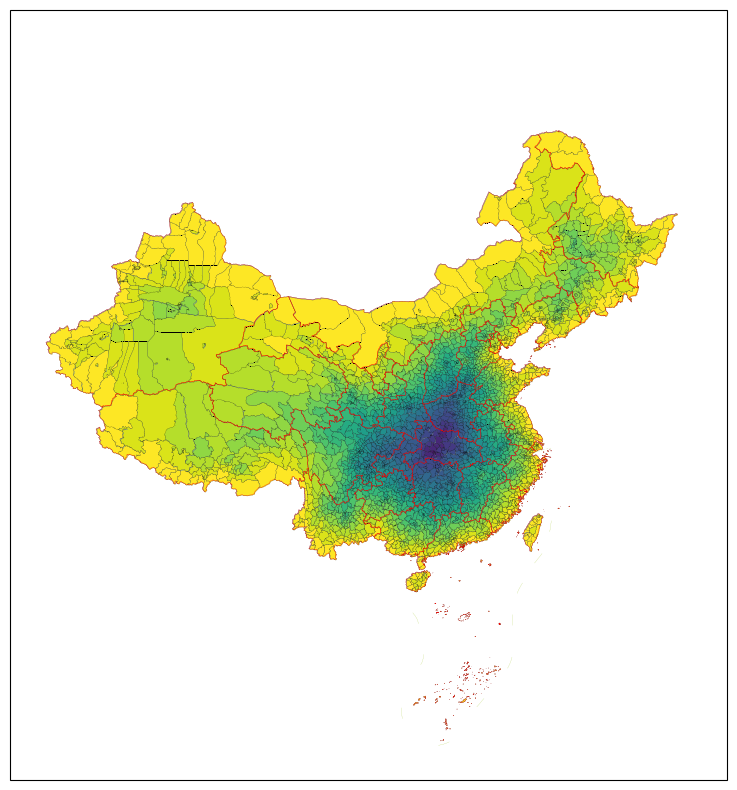

In [4]:
# 按县
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax

# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


# china_ocean_city = ['振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区',
#                     '大洼区','兴隆台区','凌海市','太和区','连山区','龙港区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
#                     '滦南县','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光市','寒亭区','昌邑市','莱州市',
#                     '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区','市北区',
#                     '市南区','李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
#                     '海安市','如东县','通州区','海门区','启东市','崇明区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
#                     '镇海区','北仑区','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
#                     '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县','福鼎市','霞浦县','福安市','蕉城区','罗源县','连江县','马尾区','长乐区','福清市',
#                     '平潭县','涵江区','荔城区','秀屿区','城厢区','仙游县','泉港区','惠安县','洛江区','丰泽区','晋江市','石狮市','南安市','翔安区','同安区','集美区',
#                     '海沧区','龙海区','思明区','湖里区','金门县','漳浦县','云霄县','东山县','诏安县','饶平县','澄海区','南澳县','龙湖区','濠江区','金平区','榕城区',
#                     '潮阳区','潮南区','惠来县','陆丰市','城区','海丰县','惠东县','惠阳区','龙岗区','盐田区','福田区','南山区','宝安区','东莞市','南沙区(广州)','中山市','香洲区',
#                     '金湾区','斗门区','新会区','台山市','阳东区','江城区','阳西县','电白区','吴川市','坡头区','霞山区','麻章区','赤坎区','遂溪县','雷州市','徐闻县',
#                     '廉江市','合浦县','铁山港区','银海区','海城区','钦南区','防城区','港口区','东兴市','文昌市','美兰区','龙华区','秀英区','澄迈县','临高县','儋州市',
#                     '昌江黎族自治县','东方市','乐东黎族自治县','崖州区','天涯区','吉阳区','海棠区','陵水黎族自治县','万宁市','琼海市','西沙区','南沙区(三沙)','基隆市','新北市',
#                     '桃园市','新竹市','新竹县','苗栗县','台中市','彰化县','云林县','嘉义县','台南市','高雄市','屏东县','台东县','花莲县','宜兰县','澎湖县','北区','元朗区',
#                     '屯门区','大埔区','西贡区','沙田区','荃湾区','葵青区','深水埗区','油尖旺区','九龙城区','观塘区','黄大仙区','中西区','湾仔区','东区','南区','离岛区','澳门特别行政区']

china_ocean_city = [ '宁明县', '凭祥市', '龙州县', '大新县', '靖西市', '那坡县', '富宁县', '麻栗坡县', '马关县', '河口瑶族自治县', '金平苗族瑶族傣族自治县', 
                     '绿春县', '江城哈尼族彝族自治县', '勐腊县', '景洪市', '勐海县', '澜沧拉祜族自治县', '孟连傣族拉祜族佤族自治县', '西盟佤族自治县', '沧源佤族自治县', 
                     '耿马傣族佤族自治县', '镇康县', '龙陵县', '芒市', '瑞丽市', '陇川县', '盈江县', '腾冲市', '泸水市', '福贡县', '贡山独龙族怒族自治县', '察隅县', 
                     '墨脱县', '错那市', '洛扎县', '浪卡子县', '康马县', '亚东县', '岗巴县', '定结县', '定日县', '聂拉木县', '吉隆县', '萨嘎县', '仲巴县', '普兰县', 
                     '札达县', '噶尔县', '日土县', '和田县', '皮山县', '叶城县', '塔什库尔干塔吉克自治县', '阿克陶县', '乌恰县', '阿图什市', '阿合奇县', '乌什县', 
                     '温宿县', '昭苏县', '察布查尔锡伯自治县', '可克达拉市', '霍城县', '霍尔果斯市', '温泉县', '博乐市', '阿拉山口市', '精河县', '托里县', '裕民县', '塔城市', 
                     '额敏县', '白杨市', '和布克赛尔蒙古自治县', '吉木乃县', '哈巴河县', '布尔津县', '阿勒泰市', '福海县', '富蕴县', '青河县', '奇台县', '木垒哈萨克自治县', 
                     '巴里坤哈萨克自治县', '伊吾县', '伊州区', '肃北蒙古族自治县', '额济纳旗', '阿拉善右旗', '阿拉善左旗', '乌拉特后旗', '乌拉特中旗', '达尔罕茂明安联合旗', 
                     '四子王旗', '苏尼特右旗', '二连浩特市', '苏尼特左旗', '阿巴嘎旗', '东乌珠穆沁旗', '科尔沁右翼前旗', '阿尔山市', '新巴尔虎左旗', '新巴尔虎右旗', '满洲里市', 
                     '陈巴尔虎旗', '额尔古纳市', '漠河市', '塔河县', '呼玛县', '爱辉区', '孙吴县', '逊克县', '嘉荫县', '萝北县', '绥滨县', '同江市', '抚远市', '饶河县', '虎林市', 
                     '密山市', '鸡东县', '穆棱市', '绥芬河市', '东宁市', '珲春市', '图们市', '龙井市', '和龙市', '安图县', '抚松县', '长白朝鲜族自治县', '临江市', 
                     '浑江区', '集安市', '宽甸满族自治县', '振安区', '元宝区',
                     '振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区',
                     '大洼区','兴隆台区','凌海市','太和区','连山区','龙港区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
                     '滦南县','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光市','寒亭区','昌邑市','莱州市',
                     '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区','市北区',
                     '市南区','李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
                     '海安市','如东县','通州区','海门区','启东市','崇明区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
                     '镇海区','北仑区','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
                     '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县','福鼎市','霞浦县','福安市','蕉城区','罗源县','连江县','马尾区','长乐区','福清市',
                     '平潭县','涵江区','荔城区','秀屿区','城厢区','仙游县','泉港区','惠安县','洛江区','丰泽区','晋江市','石狮市','南安市','翔安区','同安区','集美区',
                     '海沧区','龙海区','思明区','湖里区','金门县','漳浦县','云霄县','东山县','诏安县','饶平县','澄海区','南澳县','龙湖区','濠江区','金平区','榕城区',
                     '潮阳区','潮南区','惠来县','陆丰市','城区','海丰县','惠东县','惠阳区','龙岗区','盐田区','福田区','南山区','宝安区','东莞市','南沙区(广州)','中山市','香洲区',
                     '金湾区','斗门区','新会区','台山市','阳东区','江城区','阳西县','电白区','吴川市','坡头区','霞山区','麻章区','赤坎区','遂溪县','雷州市','徐闻县',
                     '廉江市','合浦县','铁山港区','银海区','海城区','钦南区','防城区','港口区','东兴市','文昌市','美兰区','龙华区','秀英区','澄迈县','临高县','儋州市',
                     '昌江黎族自治县','东方市','乐东黎族自治县','崖州区','天涯区','吉阳区','海棠区','陵水黎族自治县','万宁市','琼海市','西沙区','南沙区(三沙)','基隆市','新北市',
                     '桃园市','新竹市','新竹县','苗栗县','台中市','彰化县','云林县','嘉义县','台南市','高雄市','屏东县','台东县','花莲县','宜兰县','澎湖县','北区','元朗区',
                     '屯门区','大埔区','西贡区','沙田区','荃湾区','葵青区','深水埗区','油尖旺区','九龙城区','观塘区','黄大仙区','中西区','湾仔区','东区','南区','离岛区','澳门特别行政区']

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())


# for city in china_ocean_city:
#     city_data = world[world['name'] == city]
#     if not city_data.empty:
#         city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=18)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 18):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())

province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.2, transform=ccrs.PlateCarree())

# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output2.png', dpi=800, bbox_inches='tight')
plt.show()


In [ ]:
# 中国地名常见字 准备工作1
# 市县名称统计
import json
from collections import Counter
# 区县数据
with open("./shp2json/countybyprovince/西藏自治区_县.geojson", "r", encoding="utf-8") as f:
    data = json.load(f)

# 地级市数据
with open("./chinamap/province/西藏自治区.json", "r", encoding="utf-8") as f:
    data_city = json.load(f)

names = "".join([feature["properties"]["name"] for feature in data["features"]])
names += "".join([feature['properties']["name"] for feature in data_city["features"]])
print(names)
count = Counter(names)
sorted_result = dict(sorted(count.items(), key=lambda x: x[1], reverse=True))
print(sorted_result)




加查县隆子县八宿县琼结县左贡县曲松县色尼区芒康县措美县洛隆县洛扎县贡觉县曲水县类乌齐县扎囊县桑珠孜区丁青县贡嘎县察雅县巴宜区桑日县墨竹工卡县林周县当雄县江达县尼木县双湖县吉隆县聂拉木县萨嘎县岗巴县康马县定结县仲巴县亚东县班戈县巴青县尼玛县察隅县措勤县乃东区聂荣县谢通门县朗县改则县安多县白朗县申扎县仁布县索县工布江达县噶尔县城关区定日县米林市札达县堆龙德庆区萨迦县卡若区墨脱县革吉县嘉黎县达孜区拉孜县波密县日土县比如县昂仁县普兰县南木林县江孜县浪卡子县边坝县错那市拉萨市日喀则市昌都市林芝市山南市那曲市阿里地区
{'县': 64, '区': 9, '市': 8, '孜': 4, '巴': 4, '日': 4, '林': 4, '达': 4, '隆': 3, '贡': 3, '曲': 3, '尼': 3, '扎': 3, '卡': 3, '江': 3, '木': 3, '拉': 3, '萨': 3, '子': 2, '结': 2, '康': 2, '措': 2, '洛': 2, '桑': 2, '青': 2, '嘎': 2, '察': 2, '墨': 2, '工': 2, '吉': 2, '聂': 2, '定': 2, '东': 2, '朗': 2, '则': 2, '仁': 2, '布': 2, '南': 2, '那': 2, '加': 1, '查': 1, '八': 1, '宿': 1, '琼': 1, '左': 1, '松': 1, '色': 1, '芒': 1, '美': 1, '觉': 1, '水': 1, '类': 1, '乌': 1, '齐': 1, '囊': 1, '珠': 1, '丁': 1, '雅': 1, '宜': 1, '竹': 1, '周': 1, '当': 1, '雄': 1, '双': 1, '湖': 1, '岗': 1, '马': 1, '仲': 1, '亚': 1, '班': 1, '戈': 1, '玛': 1, '隅': 1, '勤': 1, '乃': 1, '荣': 1, '谢': 1, '通': 1, '门': 1, '改': 1, '安': 1, '多': 1, '白': 1, '申': 1, '索': 1, '噶': 1, '尔': 1, '城': 1, '关': 1, '米': 1, '札': 1, '堆': 1, '龙': 1

In [ ]:
# 中国地名常见字 准备工作2
# 港澳台
# hkname = '中西区东区南区湾仔区九龙城区深水埗区油尖旺区黄大仙区观塘区北区西贡区沙田区大埔区离岛区葵青区荃湾区屯门区元朗区'
mcname = '花王堂区望德堂区风顺堂区大堂区花地玛堂区嘉模堂区圣方济各堂区'
count = Counter(mcname)
sorted_result = dict(sorted(count.items(), key=lambda x: x[1], reverse=True))
print(sorted_result)

{'堂': 7, '区': 7, '花': 2, '王': 1, '望': 1, '德': 1, '风': 1, '顺': 1, '大': 1, '地': 1, '玛': 1, '嘉': 1, '模': 1, '圣': 1, '方': 1, '济': 1, '各': 1}


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


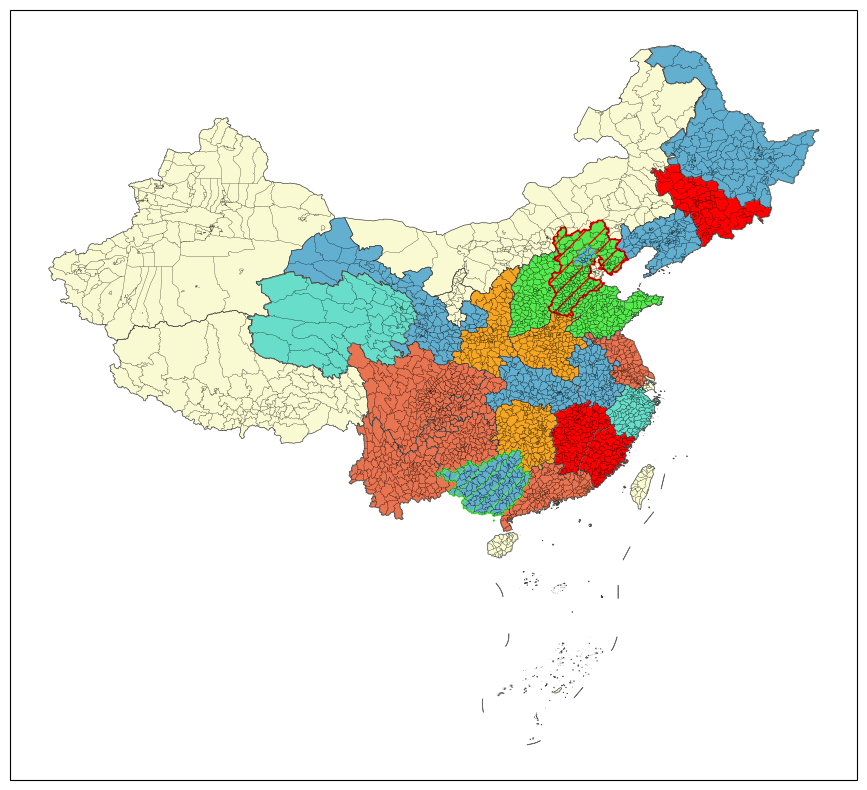

In [ ]:
# 中国地名常见字 绘图
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects

from shapely.geometry import Polygon
from matplotlib.patches import PathPatch

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def loopFillColor(china, countryList, color):
    for country in countryList:
        country_data = china[china['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='dimgray', linewidth=0.5, transform=ccrs.PlateCarree())


province_to_fill1 = ['上海市', '云南省', '内蒙古自治区', '北京市', '吉林省', '四川省', '天津市','宁夏回族自治区', '安徽省', '山东省', '山西省', 
                     '广东省','广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', 
                     '甘肃省', '福建省', '西藏自治区', '贵州省', '辽宁省', '重庆市', '陕西省', '青海省', '黑龙江省', '台湾省']

count_data = {'上海市': "浦", '云南省': '江', '内蒙古自治区': '尔','北京市': '城/山/平', '吉林省': '安', '四川省': '江', 
              '天津市': '河','宁夏回族自治区': '原', '安徽省': '山', '山东省': '城', '山西省': '城', 
              '广东省': '江','广西壮族自治区': '山/城', '新疆维吾尔自治区': '克', '江苏省': '江', '江西省': '安', 
              '河北省': '城/安', '河南省': '阳', '浙江省': '海', '海南省': '昌', '湖北省': '山', '湖南省': '阳', 
              '甘肃省': '山/临', '福建省': '安', '西藏自治区': '孜/巴/达/日/林', '贵州省': '江', '辽宁省': '山', '重庆市': '江', 
              '陕西省': '阳', '青海省': '海', '黑龙江省': '山', '台湾省': '台'}

world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

china = gpd.read_file('./chinamap/geo_china.json')
china = china.to_crs(ccrs.PlateCarree())


fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=0)})
china.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='dimgray', linewidth=0.5, transform=ccrs.PlateCarree())
# 江
jiang_group = ['四川省', '重庆市', '贵州省', '云南省', '江苏省', '广东省']
loopFillColor(china, jiang_group, "#E97451")
# 城
cheng_group = ['山西省', '山东省', '河北省', ]
loopFillColor(china, cheng_group, "#55EA4D")
# 山
shan_group = ['黑龙江省', '辽宁省', '安徽省', '湖北省', '甘肃省', '北京市', '广西壮族自治区']
loopFillColor(china, shan_group, "#63AFD0")
# 安
an_group = ['福建省', '江西省', '吉林省']
loopFillColor(china, an_group, "#FF0000")
# 阳
yang_group = ['湖南省', '陕西省', '河南省']
loopFillColor(china, yang_group, "#F5A623")
# 海
hai_group = ['浙江省', '青海省']
loopFillColor(china, hai_group, "#68DECA")

guangxi_data = china[china['name'] == '广西壮族自治区']
if not guangxi_data.empty:
    guangxi_data.plot(
        ax=ax,
        facecolor='#63AFD0', #山
        edgecolor='#55EA4D', #城
        linewidth=1.2,
        hatch='//',
        alpha=1,
        transform=ccrs.PlateCarree()
    )

hebei_data = china[china['name'] == '河北省']
if not hebei_data.empty:
    hebei_data.plot(
        ax=ax,
        facecolor='#55EA4D', #城
        edgecolor='#FF0000', #安
        linewidth=1.2,
        hatch='//',
        alpha=1,
        transform=ccrs.PlateCarree()
    )

beijing_data = china[china['name'] == '北京市']
if not beijing_data.empty:
    beijing_data.plot(
        ax=ax,
        facecolor='#63AFD0', #山
        edgecolor='#55EA4D', #城
        linewidth=0.8,
        hatch='////',
        alpha=1,
        transform=ccrs.PlateCarree()
    )

world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())
ax.tick_params(axis='both', which='both', length=0, labelsize=0)

plt.savefig('address_name.png', dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
# 欧洲各国语言中的茶
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# plt.rcParams['font.sans-serif'] = ['SimHei','Times New Roman']
# plt.rcParams['axes.unicode_minus'] = False 

world = gpd.read_file('./worldmap1/World_countries.shp')

world = world.to_crs(ccrs.PlateCarree())

countries_to_fill1 = ['英国', '法国', '西班牙', '德国', '瑞士', '意大利', '荷兰', '比利时', '丹麦', '冰岛', '瑞典', '挪威', '芬兰', '爱沙尼亚', '拉脱维亚',
                      '立陶宛', '波兰', '爱尔兰', '奥地利', '匈牙利', '卢森堡', '安道尔', '圣马力诺', '列支敦士登']
countries_to_fill2 = ['葡萄牙', '俄罗斯联邦', '白俄罗斯', '乌克兰', '土耳其', '摩尔多瓦', '捷克', '斯洛伐克', '罗马尼亚', '保加利亚', '希腊', '阿尔巴尼亚', '塞尔维亚', '斯洛文尼亚', '克罗地亚', '黑山共和国',
                      '波黑', '塞浦路斯', '前南马其顿', '格鲁吉亚']

country_word = {
    "英国": "tea/ti/te",
    "爱尔兰": "tae",
    "西班牙": "te",
    "法国": "thé",
    "荷兰": "thee",
    "德国": "Tee",
    "意大利": "tè",
    "葡萄牙": "chá",
    "罗马尼亚": "ceai",
    "捷克": "čaj",
    "波兰": "herbata",
    "挪威": "te",
    "瑞典": "te",
    "芬兰": "tee",
    "冰岛": "te",
    "希腊": "τσάι",
    "土耳其": "çay",
    "白俄罗斯": "чай",
    "立陶宛": "arbata",
    "塞尔维亚": "чај",
    "保加利亚": "чай",
    "格鲁吉亚": "ჩაი",
    "拉脱维亚": "tēja",
    "卢森堡": "Téi",
    "匈牙利": "tea"
}

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})


world.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

for country in countries_to_fill1:
    country_data = world[world['FCNAME'] == country]
    if not country_data.empty:
        country_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
    country_geom = country_data.geometry.centroid
    for x, y in zip(country_geom.x, country_geom.y):
        words = country_word.get(country, "")
        words_multiline = '\n'.join(words.split('/'))
        if words_multiline:
            ax.text(x, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')

for country in countries_to_fill2:
    country_data = world[world['FCNAME'] == country]
    if not country_data.empty:
        country_data.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
    country_geom = country_data.geometry.centroid
    for x, y in zip(country_geom.x, country_geom.y):
        words = country_word.get(country, "")
        words_multiline = '\n'.join(words.split('/'))
        if words_multiline:
            ax.text(x, y, f"{words_multiline}", horizontalalignment='center', transform=ccrs.PlateCarree(), fontsize=12, weight='bold', color='darkred')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen', markersize=10, label='tea', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightblue', markersize=10, label='chai', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='LEGEND', title_fontsize='large')
legend.get_frame().set_facecolor('lightgray')


ax.tick_params(axis='both', which='both', length=0, labelsize=0)

ax.set_extent([45, -25, 30, 68], crs=ccrs.PlateCarree())


plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()


In [1]:
# 国旗颜色

import matplotlib.pyplot as plt
import json

# 十六进制颜色转换为RGB
def hex_to_rgb(hex_color):
    return plt.cm.colors.hex2color(hex_color)  # 返回一个0到1之间的RGB元组

# RGB转换为十六进制颜色
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# 计算颜色的平均值
def average_color(colors):
    rgb_values = [hex_to_rgb(color) for color in colors]
    avg_rgb = [sum(x) / len(x) for x in zip(*rgb_values)]  # 计算每个通道的平均值
    return rgb_to_hex(avg_rgb)

# 读取 JSON 文件
def read_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# 保存处理后的数据到新的 JSON 文件
def save_json_file(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

file_path = './flag/country_colors_ch.json'  # 修改为你的 JSON 文件路径
data = read_json_file(file_path)

# 处理数据
result = []
for entry in data:
    avg_color = average_color(entry["colors"])
    result.append({
        "name": entry["name"],
        "colors": avg_color
    })

# 输出结果
print(result)

# 如果你想保存处理后的数据到一个新文件
output_file_path = 'processed_data.json'  # 结果保存的文件路径
save_json_file(output_file_path, result)


[{'name': '阿富汗', 'colors': '#7f6733'}, {'name': '阿尔巴尼亚', 'colors': '#720f10'}, {'name': '阿尔及利亚', 'colors': '#9b7b77'}, {'name': '安道尔', 'colors': '#a57c60'}, {'name': '安哥拉', 'colors': '#974d14'}, {'name': '安提瓜和巴布达', 'colors': '#8e7766'}, {'name': '阿根廷', 'colors': '#b08e67'}, {'name': '亚美尼亚', 'colors': '#99493b'}, {'name': '澳大利亚', 'colors': '#aa5583'}, {'name': '奥地利', 'colors': '#f6949c'}, {'name': '阿塞拜疆', 'colors': '#8a9f94'}, {'name': '巴哈马', 'colors': '#538359'}, {'name': '巴林', 'colors': '#e68892'}, {'name': '孟加拉国', 'colors': '#7a4a47'}, {'name': '巴巴多斯', 'colors': '#554f37'}, {'name': '白俄罗斯', 'colors': '#b09c86'}, {'name': '比利时', 'colors': '#f3843d'}, {'name': '伯利兹', 'colors': '#776e43'}, {'name': '贝宁', 'colors': '#a17831'}, {'name': '不丹', 'colors': '#b37b55'}, {'name': '玻利维亚', 'colors': '#9a821b'}, {'name': '波黑', 'colors': '#a9a486'}, {'name': '博茨瓦纳', 'colors': '#bad4ed'}, {'name': '巴西', 'colors': '#7fa86b'}, {'name': '文莱', 'colors': '#b17c4f'}, {'name': '保加利亚', 'colors': '#9c937f'}, 

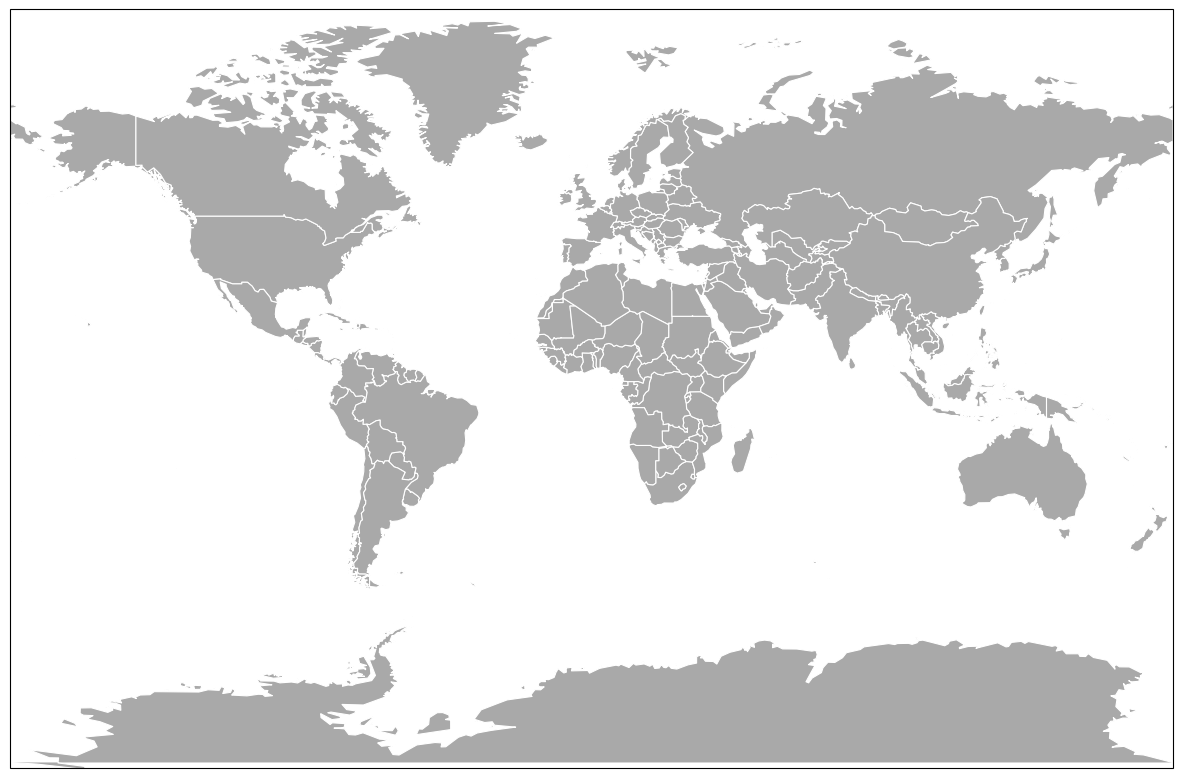

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from PIL import Image
import os


flags_folder = './flag/w2560'  # 国旗文件所在的目录
flags = {
    '中国': '中国.png',
    '韩国': '韩国.png',
    '日本': '日本.png',
    '朝鲜': '朝鲜.png',
    '蒙古': '蒙古.png'
}

# 获取并调整国旗大小
def get_resized_flag(flag_path, target_size):
    with Image.open(flag_path) as img:
        return img.resize(target_size, Image.ANTIALIAS)
    

world = gpd.read_file('./worldmap4/world.json')
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=0)})
world.plot(ax=ax, color='darkgray', edgecolor='white', linewidth=0.8, transform=ccrs.PlateCarree())
ax.set_global()
ax.set_extent([-180, 180, -85, 85])


# 显示绘图
plt.show()


In [ ]:
import geopandas as gpd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon, Polygon
from shapely.affinity import translate, scale
import cartopy.crs as ccrs

# 1. 读取GeoJSON文件和目标元素的几何形状
geojson_file = './worldmap4/world.json'  # 替换为你的GeoJSON文件路径
world = gpd.read_file(geojson_file)
world = world.to_crs(ccrs.Miller())

# 假设我们要裁剪名为 'China' 的元素
target_name = '中国'
target_geometry = world[world['name'] == target_name].geometry.iloc[0]
if isinstance(target_geometry, MultiPolygon):
    # 使用 geoms 属性来迭代 MultiPolygon 中的每个 Polygon
    largest_polygon = max(target_geometry.geoms, key=lambda poly: poly.area)
else:
    # 如果是单个 Polygon，直接使用
    largest_polygon = target_geometry

# 2. 加载PNG图像
# image_path = './flag/example_flags/china.png'  # 替换为你的PNG图像路径
image_path = 'test2.jpg'
image = Image.open(image_path).convert('RGBA')  # 确保图片是RGBA模式（即含有透明度）

# 获取图像的宽度和高度
img_width, img_height = image.size

# 3. 创建一个空的掩膜（mask），与图像大小相同，初始化为全黑（即完全透明）
mask = Image.new('L', (img_width, img_height), 0)  # 'L'模式代表灰度图像

# 4. 将目标几何形状（如多边形）的轮廓绘制到掩膜图像上
draw = ImageDraw.Draw(mask)
# 将目标几何转换为像素坐标，适应图像大小
minx, miny, maxx, maxy = largest_polygon.bounds
scale_x = img_width / (maxx - minx)
scale_y = img_height / (maxy - miny)

# 将几何转换为适应图像坐标系的多边形
translated_polygon = translate(largest_polygon, xoff=-minx, yoff=-miny)
scaled_polygon = scale(translated_polygon, xfact=scale_x, yfact=scale_y, origin=(0,0))

# 通过绘制目标几何的多边形轮廓来创建掩膜
origin_coors = list(scaled_polygon.exterior.coords)
flipped_coords = [(x, abs(y - 2*(scaled_polygon.bounds[3]/2))) for x, y in origin_coors]
draw.polygon(flipped_coords, fill=255) 
# 5. 将掩膜应用到原图像，裁剪出与目标几何形状相同的区域
# 使用掩膜（mask）在图像上进行裁剪，保持非透明区域
result_image = Image.composite(image, Image.new('RGBA', (img_width, img_height), (0, 0, 0, 0)), mask)
result_image.show()

# 如果你想保存裁剪后的图像
# result_image.save('./clipped_image.png')



(8196636.782393125, 2286460.031098187, 15037415.970541036, 6609035.965522045)


In [12]:
import geopandas as gpd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon, Polygon
from shapely.affinity import translate, scale
import cartopy.crs as ccrs

# 1. 读取GeoJSON文件和目标元素的几何形状
geojson_file = './worldmap4/world.json'  # 替换为你的GeoJSON文件路径
world = gpd.read_file(geojson_file)
world = world.to_crs(ccrs.Miller())

# 假设我们要裁剪名为 'China' 的元素
target_name = '美国'
target_geometry = world[world['name'] == target_name].geometry.iloc[0]
if isinstance(target_geometry, MultiPolygon):
    # 从 MultiPolygon 中提取所有的 Polygon
    polygons = target_geometry.geoms
    
    # 按面积降序排序，取最大的三个
    largest_polygons = sorted(polygons, key=lambda poly: poly.area, reverse=True)[:1]
    
    # 合并这三个最大的 Polygon 形成新的 MultiPolygon
    combined_geometry = MultiPolygon(largest_polygons)
else:
    # 如果目标几何是单个 Polygon，直接使用
    combined_geometry = target_geometry

# 2. 加载PNG图像
# image_path = './flag/example_flags/china.png'  # 替换为你的PNG图像路径
image_path = 'test2.jpg'
image = Image.open(image_path).convert('RGBA')  # 确保图片是RGBA模式（即含有透明度）

# 获取图像的宽度和高度
img_width, img_height = image.size

# 3. 创建一个空的掩膜（mask），与图像大小相同，初始化为全黑（即完全透明）
mask = Image.new('L', (img_width, img_height), 0)  # 'L'模式代表灰度图像

# 4. 将目标几何形状（如多边形）的轮廓绘制到掩膜图像上
draw = ImageDraw.Draw(mask)
# 将目标几何转换为像素坐标，适应图像大小
minx, miny, maxx, maxy = combined_geometry.bounds
scale_x = img_width / (maxx - minx)
scale_y = img_height / (maxy - miny)

# 将几何转换为适应图像坐标系的多边形
translated_polygon = translate(combined_geometry, xoff=-minx, yoff=-miny)
scaled_polygon = scale(translated_polygon, xfact=scale_x, yfact=scale_y, origin=(0,0))

# 通过绘制目标几何的多边形轮廓来创建掩膜
if isinstance(scaled_polygon, MultiPolygon):
    # 遍历所有 Polygon，获取它们的 exterior 坐标
    # all_coords = [list(poly.exterior.coords) for poly in scaled_polygon.geoms]
    all_coords = [coord for poly in scaled_polygon.geoms for coord in poly.exterior.coords]
else:
    # 如果是单个 Polygon
    all_coords = [list(scaled_polygon.exterior.coords)]


flipped_coords = [(x, abs(y - 2*(scaled_polygon.bounds[3]/2))) for x, y in all_coords]
draw.polygon(flipped_coords, fill=255) 
# 5. 将掩膜应用到原图像，裁剪出与目标几何形状相同的区域
# 使用掩膜（mask）在图像上进行裁剪，保持非透明区域
result_image = Image.composite(image, Image.new('RGBA', (img_width, img_height), (0, 0, 0, 0)), mask)
result_image.show()




Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


#fde725
['鄂州市', '黄冈市', '武汉市', '黄石市', '重庆市', '池州市', '马鞍山市', '无锡市', '南京市', '芜湖市', '常州市', '曲靖市', '楚雄彝族自治州', '攀枝花市', '昆明市', '凉山彝族自治州', '丽江市', '大理白族自治州', '宜昌市', '荆州市', '迪庆藏族自治州', '甘孜藏族自治州', '昌都市', '宜宾市', '泸州市', '昭通市', '铜陵市', '安庆市', '岳阳市', '九江市', '咸宁市', '扬州市', '泰州市', '南通市', '恩施土家族苗族自治州', '镇江市', '玉树藏族自治州', '海西蒙古族藏族自治州', '上海市', '苏州市']
#c8e020
['舟山市', '广安市', '达州市', '遂宁市', '宣城市', '黄山市', '湖州市', '六盘水市', '黔西南布依族苗族自治州', '毕节市', '景德镇市', '上饶市', '普洱市', '玉溪市', '安康市', '荆门市', '孝感市', '潜江市', '襄阳市', '嘉兴市', '怒江傈僳族自治州', '林芝市', '自贡市', '乐山市', '遵义市', '长沙市', '宜春市', '内江市', '百色市', '文山壮族苗族自治州', '合肥市', '益阳市', '仙桃市', '信阳市', '雅安市', '阿坝藏族羌族自治州', '十堰市', '盐城市', '淮安市', '巴音郭楞蒙古自治州', '红河哈尼族彝族自治州', '果洛藏族自治州', '常德市', '张家界市', '滁州市', '六安市', '资阳市', '铜仁市', '南昌市', '湘西土家族苗族自治州', '三亚市', '保亭黎族苗族自治县', '陵水黎族自治县', '乐东黎族自治县', '台湾省', '神农架林区', '保山市', '琼中黎族苗族自治县', '五指山市', '张掖市', '海北藏族自治州', '万宁市', '昌江黎族自治县', '白沙黎族自治县', '东方市', '儋州市', '临高县', '澄迈县', '屯昌县', '定安县', '海口市', '琼海市', '文昌市', '酒泉市', '那曲市', '临沧市', '海南藏族自治州', '三沙市']
#90d743
['南充市', '杭州市', '安

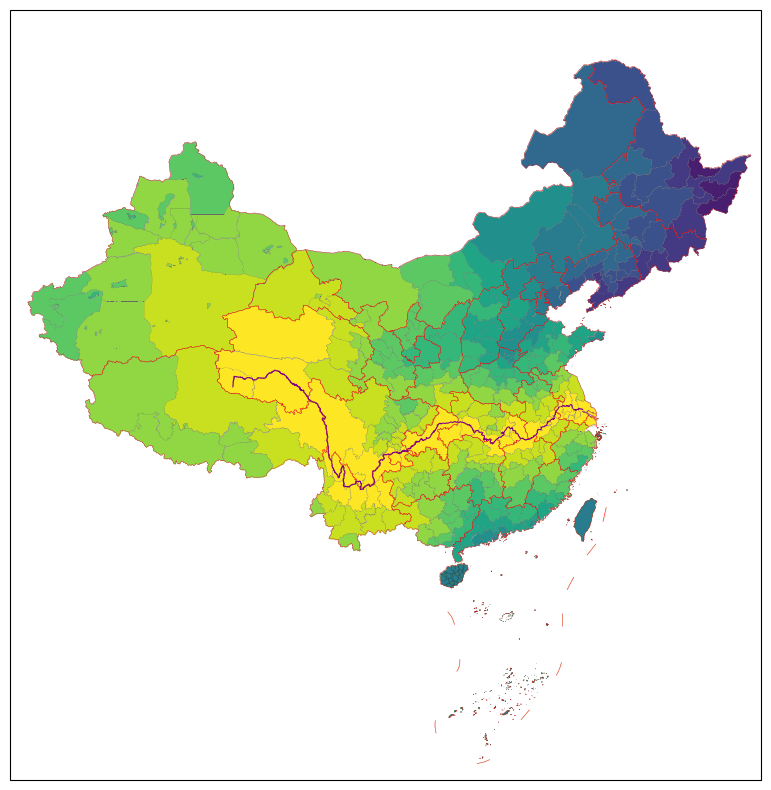

In [1]:
# 长江彩带
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(ax, world, countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax

# 读取地图数据
world_big = gpd.read_file('./chinamap/geo_china.json')
world_big = world_big.to_crs(ccrs.PlateCarree())
world = gpd.read_file('./shp2json/chinacity.geojson')
world = world.to_crs(ccrs.PlateCarree())
province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())
river1 = gpd.read_file('./river/level1/level1.shp')
river1 = river1.to_crs(ccrs.PlateCarree())
changjiang = river1[river1['NAME'] == '长江'] 
jinshajiang = river1[river1['NAME'] == '金沙江']
tongtianhe = river1[river1['NAME'] == '通天河']
tuotuohe = river1[river1['NAME'] == '沱沱河']
river = pd.concat([changjiang, jinshajiang, tongtianhe, tuotuohe])

G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ["上海市","苏州市","南通市","泰州市","无锡市","常州市","镇江市","扬州市","南京市","马鞍山市","芜湖市","铜陵市","池州市","安庆市",
                    "九江市","黄冈市","黄石市","咸宁市","鄂州市","武汉市","荆州市","岳阳市","宜昌市","恩施土家族苗族自治州","重庆市","泸州市","宜宾市",
                    "昭通市","曲靖市","昆明市","楚雄彝族自治州","大理白族自治州","凉山彝族自治州","攀枝花市","丽江市","迪庆藏族自治州","甘孜藏族自治州",
                    "昌都市","玉树藏族自治州","海西蒙古族藏族自治州"]


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=12)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 12):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    color = scalarMap.to_rgba(i)
    hex_color = mcolors.to_hex(color)
    print(hex_color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='dimgray', linewidth=0.1, transform=ccrs.PlateCarree())

province_bug_fixed = ['海口市', '澄迈县', '临高县', '儋州市', '昌江黎族自治县', '东方市', '乐东黎族自治县', '三亚市', 
                      '陵水黎族自治县', '万宁市', '琼海市', '文昌市', '定安县', '屯昌县', '琼中黎族苗族自治县', '白沙黎族自治县',
                      '五指山市', '保亭黎族苗族自治县', '三沙市', '台湾省', '舟山市']
loopFillColor(ax, world, province_bug_fixed, '#287C8E')
world_big.plot(ax=ax, color='none', edgecolor='red', linewidth=0.2, transform=ccrs.PlateCarree())
# province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.2, transform=ccrs.PlateCarree())
river.plot(ax=ax, color='purple', linewidth=0.8, transform=ccrs.PlateCarree())

# legend_elements = [
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#fde725', markersize=10, label='长江流经此市(地级市，下同)', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#5cc863', markersize=10, label='此市与长江间隔1个市', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#21908d', markersize=10, label='此市与长江间隔2个市', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#3b518b', markersize=10, label='此市与长江间隔3个市', linestyle='None'),
#     Line2D([0], [0], marker='_', color='purple', markersize=10, label='长江', linestyle='None'),
#     Line2D([0], [0], marker='_', color='red', markersize=10, label='省界', linestyle='None')
# ]
# legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 14})
# legend.get_frame().set_facecolor('lightgray')

# 设置地图显示范围
ax.set_extent([72, 136, 2, 56], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('长江彩带.png', dpi=2000, bbox_inches='tight')
plt.show()


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


#ffffcc
['吕梁市', '榆林市', '忻州市', '延安市', '临汾市', '濮阳市', '菏泽市', '新乡市', '聊城市', '济宁市', '泰安市', '渭南市', '济南市', '滨州市', '德州市', '淄博市', '中卫市', '吴忠市', '阿坝藏族羌族自治州', '三门峡市', '甘南藏族自治州', '临夏回族自治州', '海东市', '果洛藏族自治州', '黄南藏族自治州', '呼和浩特市', '包头市', '鄂尔多斯市', '东营市', '开封市', '巴彦淖尔市', '玉树藏族自治州', '白银市', '焦作市', '郑州市', '乌海市', '石嘴山市', '阿拉善盟', '运城市', '济源市', '洛阳市', '兰州市', '银川市', '海南藏族自治州']
#fff3af
['太原市', '晋中市', '舟山市', '邯郸市', '安阳市', '西安市', '商洛市', '咸阳市', '徐州市', '商丘市', '宿州市', '石家庄市', '阳泉市', '邢台市', '保定市', '衡水市', '甘孜藏族自治州', '昌都市', '庆阳市', '平凉市', '固原市', '临沂市', '枣庄市', '潍坊市', '雅安市', '成都市', '周口市', '南阳市', '太子山天然林保护区', '巴音郭楞蒙古自治州', '莲花山风景林自然保护区', '定西市', '陇南市', '德阳市', '绵阳市', '大同市', '朔州市', '乌兰察布市', '长治市', '三亚市', '保亭黎族苗族自治县', '陵水黎族自治县', '乐东黎族自治县', '台湾省', '鹤壁市', '琼中黎族苗族自治县', '五指山市', '张掖市', '金昌市', '海北藏族自治州', '万宁市', '昌江黎族自治县', '白沙黎族自治县', '东方市', '沧州市', '儋州市', '许昌市', '临高县', '澄迈县', '屯昌县', '定安县', '海口市', '琼海市', '文昌市', '晋城市', '酒泉市', '那曲市', '海西蒙古族藏族自治州', '平顶山市', '武威市', '西宁市', '三沙市', '铜川市']
#ffe793
['南充市', '遂宁市', '凉山彝族自治州', '安康市', '汉中市', '宝鸡市', '

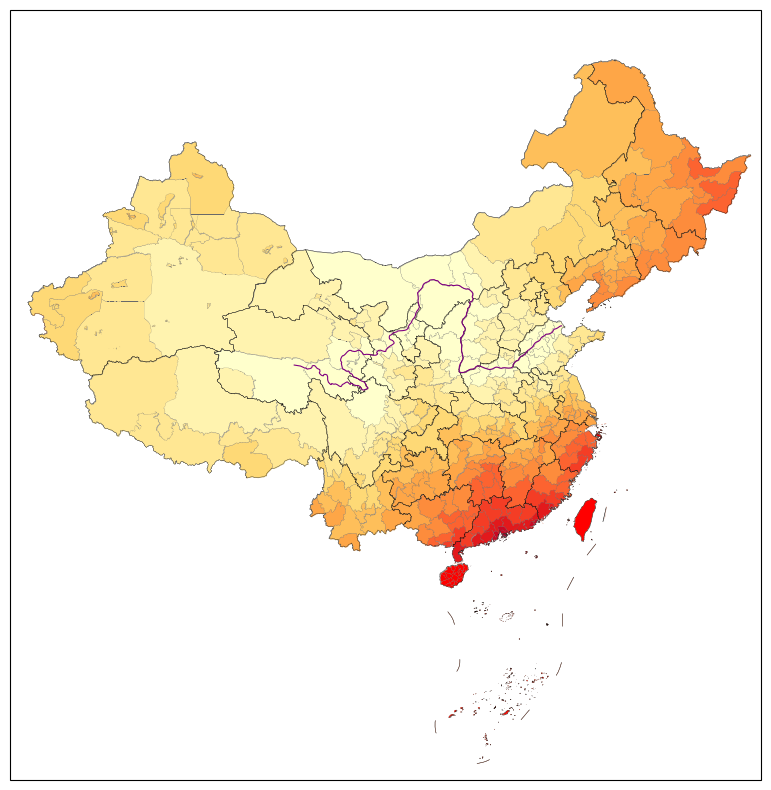

In [16]:
# 黄河彩带
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(ax, world, countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='dimgray', linewidth=0.1, transform=ccrs.PlateCarree())


def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax

# 读取地图数据
world_big = gpd.read_file('./chinamap/geo_china.json')
world_big = world_big.to_crs(ccrs.PlateCarree())
world = gpd.read_file('./shp2json/chinacity.geojson')
world = world.to_crs(ccrs.PlateCarree())
province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

river2 = gpd.read_file('./shp2json/world_river_50m.geojson')
huanghe = river2[(river2['name_zh'] == '黄河') ]
huanghe = huanghe.to_crs(ccrs.PlateCarree())

G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ["东营市","滨州市","淄博市","济南市","德州市","泰安市","聊城市","濮阳市","济宁市","菏泽市","新乡市","开封市","郑州市","焦作市",
                    "洛阳市","三门峡市","济源市","渭南市","运城市","延安市","临汾市","吕梁市","榆林市","忻州市","呼和浩特市","鄂尔多斯市","包头市",
                    "巴彦淖尔市","阿拉善盟","乌海市","石嘴山市","银川市","吴忠市","中卫市","白银市","兰州市","临夏回族自治州",
                    "海东市","甘南藏族自治州","黄南藏族自治州","海南藏族自治州","果洛藏族自治州","玉树藏族自治州","阿坝藏族羌族自治州"]


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='darkgray', edgecolor='dimgray', linewidth=0.1, transform=ccrs.PlateCarree())

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=12)
scalarMap = cm.ScalarMappable(norm=norm, cmap='YlOrRd')

for i in range(0, 12):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    color = scalarMap.to_rgba(i)
    hex_color = mcolors.to_hex(color)
    print(hex_color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='dimgray', linewidth=0.1, transform=ccrs.PlateCarree())

province_bug_fixed = ['海口市', '澄迈县', '临高县', '儋州市', '昌江黎族自治县', '东方市', '乐东黎族自治县', '三亚市', 
                      '陵水黎族自治县', '万宁市', '琼海市', '文昌市', '定安县', '屯昌县', '琼中黎族苗族自治县', '白沙黎族自治县',
                      '五指山市', '保亭黎族苗族自治县', '三沙市', '台湾省', '舟山市']
loopFillColor(ax, world, province_bug_fixed, 'red')
world_big.plot(ax=ax, color='none', edgecolor='k', linewidth=0.2, transform=ccrs.PlateCarree())
# province.plot(ax=ax, color='none', edgecolor='red', linewidth=0.2, transform=ccrs.PlateCarree())
huanghe.plot(ax=ax, color='purple', linewidth=0.8, transform=ccrs.PlateCarree())

# legend_elements = [
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#fde725', markersize=10, label='黄河流经此市(地级市，下同)', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#5cc863', markersize=10, label='此市与黄河间隔1个市', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#21908d', markersize=10, label='此市与黄河间隔2个市', linestyle='None'),
#     Line2D([0], [0], marker='s', color='k', markerfacecolor='#3b518b', markersize=10, label='此市与黄河间隔3个市', linestyle='None'),
#     Line2D([0], [0], marker='_', color='purple', markersize=10, label='黄河', linestyle='None'),
#     Line2D([0], [0], marker='_', color='red', markersize=10, label='省界', linestyle='None')
# ]
# legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 14})
# legend.get_frame().set_facecolor('lightgray')

# 设置地图显示范围
ax.set_extent([72, 136, 2, 56], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('黄河彩带2.png', dpi=2000, bbox_inches='tight')
plt.show()


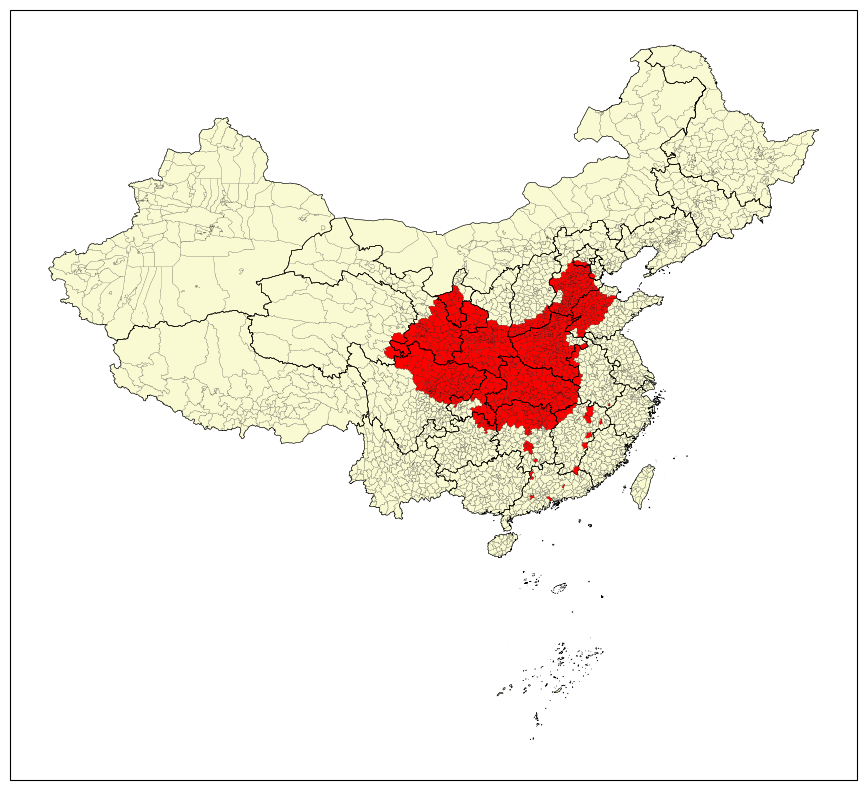

In [8]:
# 县城画图
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./chinamap/china_china.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.4, linestyle='-', transform=ccrs.PlateCarree())

# plugin
countries_to_fill1 = ['嘉禾县', '连山壮族瑶族自治县', '云城区', '南沙区(广州)', '源城区', '寻乌县', '广昌县', '南城县', '横峰县', '屯溪区',]
loopFillColor(countries_to_fill1, 'red')

# 设置地图显示范围
# ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('china_chn.png', dpi=1200, bbox_inches='tight')
plt.show()


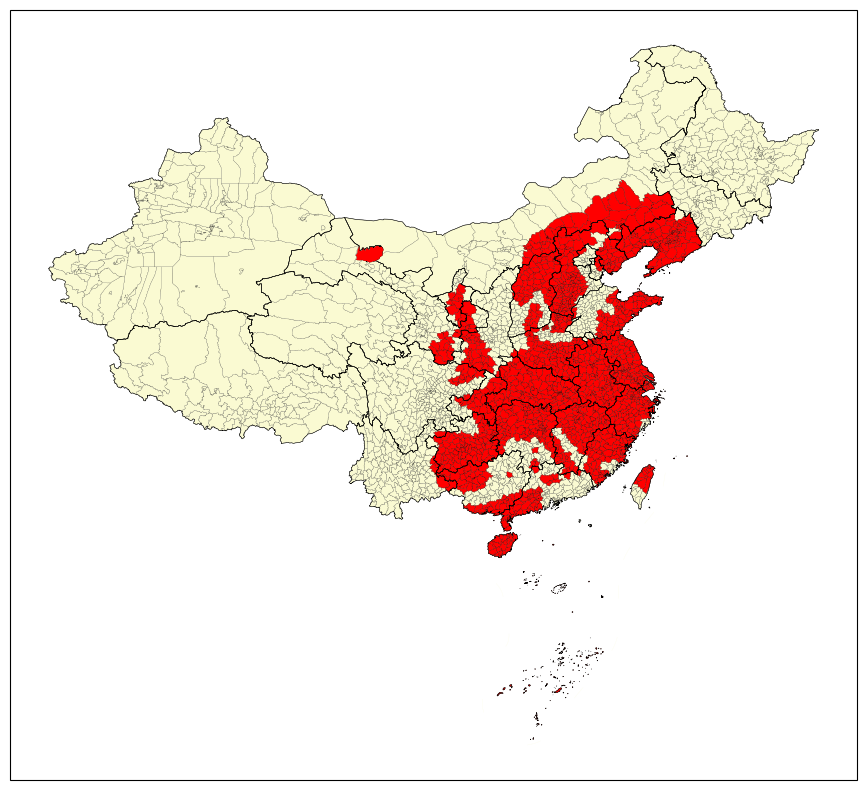

In [4]:
# 县城画图
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())
            

# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./chinamap/china_eu.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())
minimapplugin = gpd.read_file('./chinamap/china_eu_plugin.geojson')
minimapplugin = minimapplugin.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimapplugin.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.4, linestyle='-', transform=ccrs.PlateCarree())
countries_to_fill1 = ['金塔县']
loopFillColor(countries_to_fill1, 'red')

# 设置地图显示范围
# ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('chn_eu.png', dpi=1200, bbox_inches='tight')
plt.show()


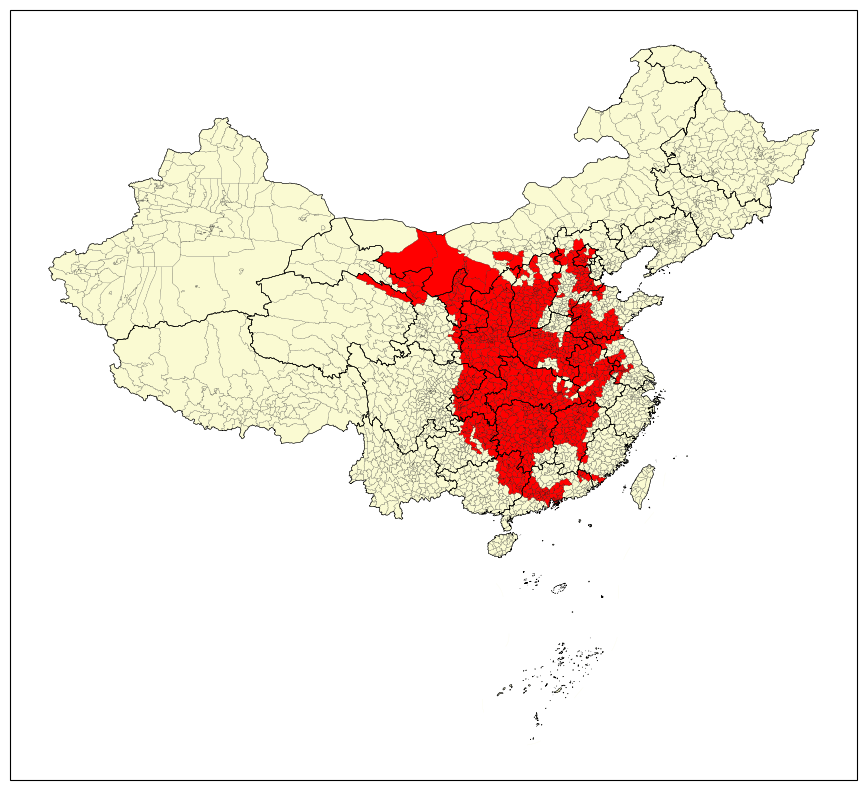

In [1]:
# 县城画图
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./chinamap/china_na.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.4, linestyle='-', transform=ccrs.PlateCarree())

# 设置地图显示范围
# ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=1200, bbox_inches='tight')
plt.show()


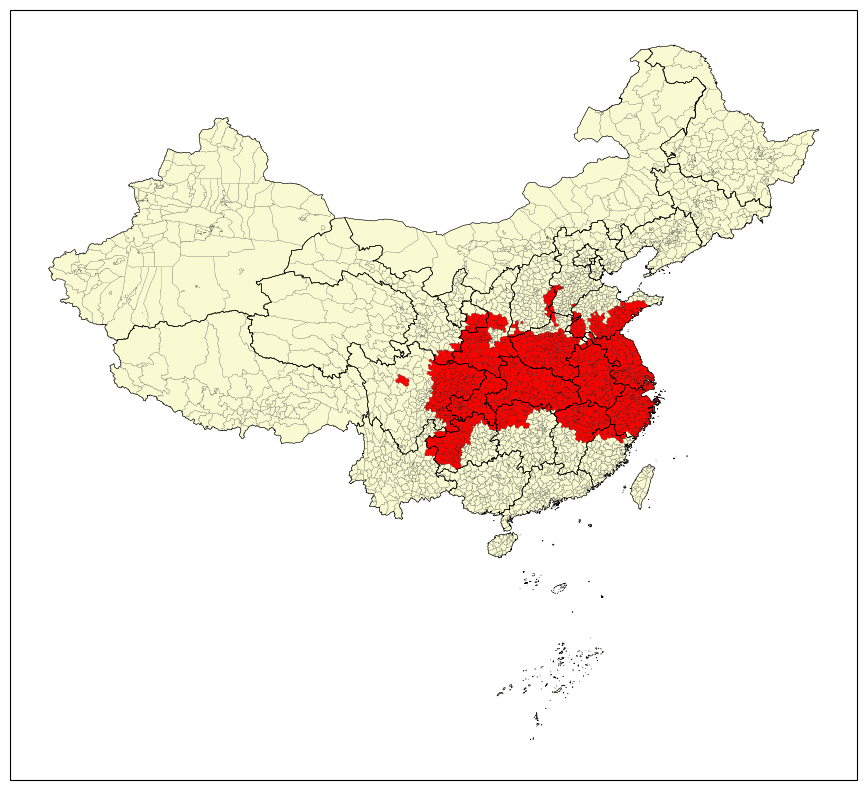

In [5]:
# 县城画俄罗斯
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


# 读取地图数据
world = gpd.read_file('./shp2json/chinacounty.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/chinaprovince.geojson')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./chinamap/china_russia.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.4, linestyle='-', transform=ccrs.PlateCarree())

countries_to_fill1 = ['金川县']
loopFillColor(countries_to_fill1, 'red')

# 设置地图显示范围
# ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=1200, bbox_inches='tight')
plt.show()


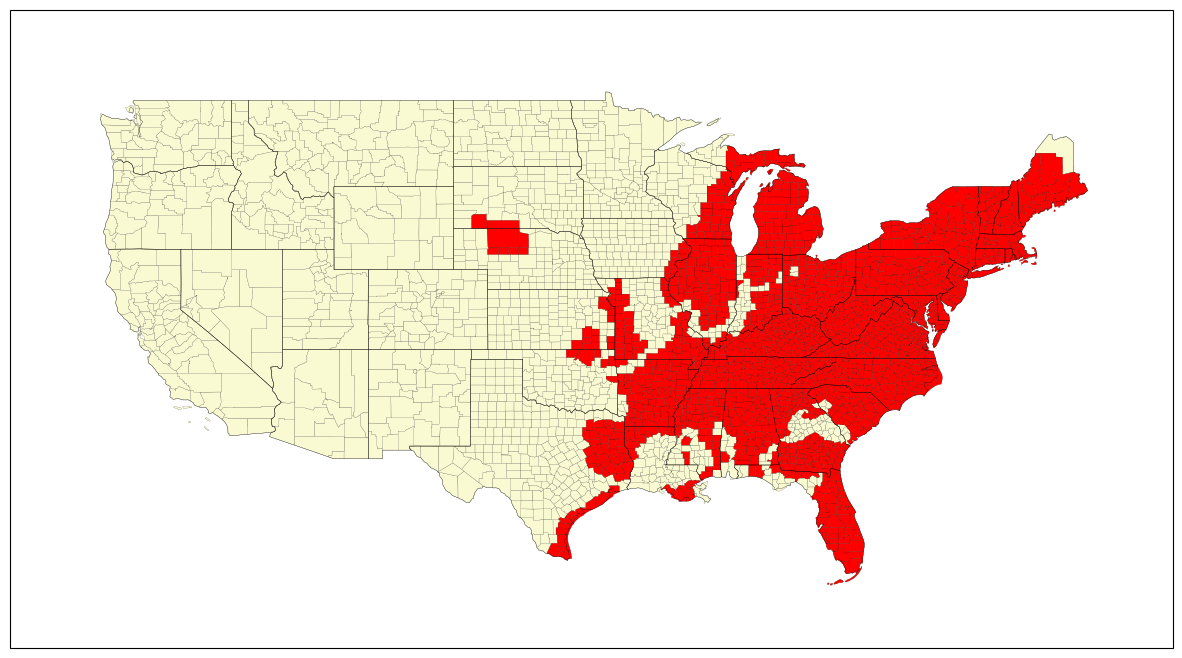

In [1]:
# 美国县画欧洲
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


# 读取地图数据
world = gpd.read_file('./shp2json/us_county.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/us_state.json')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./shp2json/us_eu.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.2, linestyle='-', transform=ccrs.PlateCarree())

# 设置地图显示范围
ax.set_extent([-130, -62, 21, 53], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=1200, bbox_inches='tight')
plt.show()


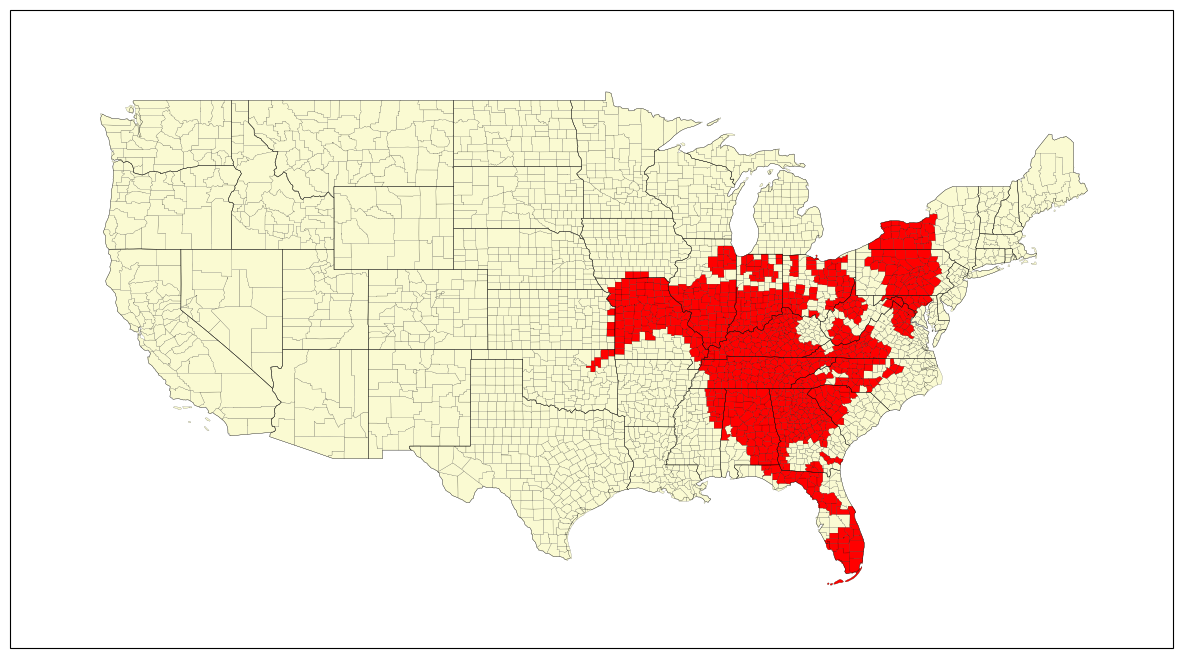

In [2]:
# 美国县画北美
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


# 读取地图数据
world = gpd.read_file('./shp2json/us_county.geojson')
world = world.to_crs(ccrs.PlateCarree())

province = gpd.read_file('./shp2json/us_state.json')
province = province.to_crs(ccrs.PlateCarree())

minimap = gpd.read_file('./shp2json/us_na.geojson')
minimap = minimap.to_crs(ccrs.PlateCarree())


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=150)})
world.plot(ax=ax, color='lightgoldenrodyellow', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
minimap.plot(ax=ax, color='red', edgecolor='black', linewidth=0.1, transform=ccrs.PlateCarree())
province.plot(ax=ax, color='none', edgecolor='k', linewidth=0.2, linestyle='-', transform=ccrs.PlateCarree())

# 设置地图显示范围
ax.set_extent([-130, -62, 21, 53], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('us_na.png', dpi=1200, bbox_inches='tight')
plt.show()


In [24]:
# 七大洲平均国旗颜色求取

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import json

plt.rcParams['font.sans-serif'] = ['SimHei','Times New Roman']
plt.rcParams['axes.unicode_minus'] = False


def read_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)


def save_json_file(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)


def hex_to_rgb(hex_color):
    return plt.cm.colors.hex2color(hex_color)


def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))


def average_color(colors):
    rgb_values = [hex_to_rgb(color) for color in colors]
    avg_rgb = [sum(x) / len(x) for x in zip(*rgb_values)]
    return rgb_to_hex(avg_rgb)


def country2color(CountryList):
    mix_color_data = read_json_file('./flag/country_colors_ch_power_mix.json')
    flag_color_list = []
    for country in CountryList:
        print(f"开始查找国家: {country} 的国旗颜色数据...")
        result = next((item for item in mix_color_data if item['name'] == country), None)
        if result:
            print(f"国家：{country}的国旗颜色数据已累积")
            flag_color_list.append(result['weighted_average_color'])
        else:
            print(f"国家：{country}无国旗颜色数据")

    if len(flag_color_list) != 0:
        avg_color = average_color(flag_color_list)
        print(f"{CountryList}的平均国旗颜色是{avg_color}")


asiaCountryList = ['中国', '日本', '韩国', '朝鲜', '蒙古', '印度', '巴基斯坦', '孟加拉国', '斯里兰卡', '尼泊尔',
                  '不丹', '马尔代夫', '阿富汗', '哈萨克斯坦', '乌兹别克斯坦', '土库曼斯坦', '吉尔吉斯斯坦', '塔吉克斯坦',
                  '伊朗', '伊拉克', '叙利亚', '黎巴嫩', '约旦', '以色列', '沙特阿拉伯', '阿联酋','卡塔尔', '科威特', '巴林', 
                  '阿曼', '也门', '土耳其', '塞浦路斯', '格鲁吉亚', '亚美尼亚', '阿塞拜疆', '越南', '泰国','马来西亚', '新加坡', 
                  '菲律宾', '印度尼西亚', '缅甸', '柬埔寨', '老挝', '文莱', '东帝汶', '俄罗斯', '埃及']
europeCountryList = ['英国', '法国', '德国', '意大利', '西班牙', '葡萄牙', '荷兰', '比利时', '瑞士', '奥地利','挪威', '瑞典', '芬兰', 
                     '丹麦', '爱尔兰', '希腊', '土耳其', '波兰', '捷克', '匈牙利', '斯洛伐克','罗马尼亚', '保加利亚', '塞尔维亚', '克罗地亚', 
                     '斯洛文尼亚', '波黑', '黑山', '北马其顿', '阿尔巴尼亚', '乌克兰', '白俄罗斯','立陶宛', '拉脱维亚', '爱沙尼亚', '冰岛', '卢森堡', 
                     '摩纳哥', '列支敦士登', '圣马力诺', '安道尔', '马耳他','俄罗斯', '摩尔多瓦', '哈萨克斯坦']
africaCountryList = ['南非', '埃及', '尼日利亚', '肯尼亚', '坦桑尼亚', '乌干达', '加纳', '安哥拉', '莫桑比克', '马达加斯加', '赞比亚', '津巴布韦', 
                     '马拉维', '博茨瓦纳', '纳米比亚', '卢旺达', '布隆迪', '塞舌尔', '毛里求斯', '科摩罗', '索马里', '埃塞俄比亚', '吉布提', 
                     '厄立特里亚', '苏丹', '南苏丹', '乍得', '尼日尔', '马里', '布基纳法索', '科特迪瓦', '多哥', '贝宁', '佛得角', '几内亚比绍', 
                     '斯威士兰', '莱索托','塞拉利昂', '利比里亚', '冈比亚', '几内亚', '圣多美和普林西比', '中非', '刚果（布）', '刚果（金）',
                     '加蓬', '赤道几内亚', '喀麦隆', '利比亚', '突尼斯', '阿尔及利亚', '摩洛哥', '毛里塔尼亚', '塞内加尔']
northAmericaCountryList = ['美国', '加拿大', '墨西哥', '古巴', '牙买加', '多米尼加', '海地', '特立尼达和多巴哥', '巴哈马', '巴巴多斯', '伯利兹', '危地马拉',
                           '圣卢西亚', '格林纳达', '圣文森特和格林纳丁斯', '安提瓜和巴布达', '圣基茨和尼维斯', '多米尼克', '哥斯达黎加', '尼加拉瓜', '洪都拉斯',
                           '萨尔瓦多', '巴拿马', '丹麦']
southAmericaCountryList = ['巴西', '阿根廷', '哥伦比亚', '智利', '秘鲁', '委内瑞拉', '乌拉圭', '玻利维亚', '厄瓜多尔', '巴拉圭', '圭亚那', '苏里南', '法国']
oceaniaCountryList = ['澳大利亚', '新西兰', '巴布亚新几内亚', '斐济', '所罗门群岛', '瓦努阿图', '基里巴斯', '汤加', '萨摩亚', '图瓦卢', 
                      '密克罗尼西亚联邦', '帕劳', '马绍尔群岛', '瑙鲁', '印度尼西亚']

country2color(oceaniaCountryList)




开始查找国家: 澳大利亚 的国旗颜色数据...
国家：澳大利亚的国旗颜色数据已累积
开始查找国家: 新西兰 的国旗颜色数据...
国家：新西兰的国旗颜色数据已累积
开始查找国家: 巴布亚新几内亚 的国旗颜色数据...
国家：巴布亚新几内亚的国旗颜色数据已累积
开始查找国家: 斐济 的国旗颜色数据...
国家：斐济的国旗颜色数据已累积
开始查找国家: 所罗门群岛 的国旗颜色数据...
国家：所罗门群岛的国旗颜色数据已累积
开始查找国家: 瓦努阿图 的国旗颜色数据...
国家：瓦努阿图的国旗颜色数据已累积
开始查找国家: 基里巴斯 的国旗颜色数据...
国家：基里巴斯的国旗颜色数据已累积
开始查找国家: 汤加 的国旗颜色数据...
国家：汤加的国旗颜色数据已累积
开始查找国家: 萨摩亚 的国旗颜色数据...
国家：萨摩亚的国旗颜色数据已累积
开始查找国家: 图瓦卢 的国旗颜色数据...
国家：图瓦卢的国旗颜色数据已累积
开始查找国家: 密克罗尼西亚联邦 的国旗颜色数据...
国家：密克罗尼西亚联邦的国旗颜色数据已累积
开始查找国家: 帕劳 的国旗颜色数据...
国家：帕劳的国旗颜色数据已累积
开始查找国家: 马绍尔群岛 的国旗颜色数据...
国家：马绍尔群岛的国旗颜色数据已累积
开始查找国家: 瑙鲁 的国旗颜色数据...
国家：瑙鲁的国旗颜色数据已累积
开始查找国家: 印度尼西亚 的国旗颜色数据...
国家：印度尼西亚的国旗颜色数据已累积
['澳大利亚', '新西兰', '巴布亚新几内亚', '斐济', '所罗门群岛', '瓦努阿图', '基里巴斯', '汤加', '萨摩亚', '图瓦卢', '密克罗尼西亚联邦', '帕劳', '马绍尔群岛', '瑙鲁', '印度尼西亚']的平均国旗颜色是#675c77


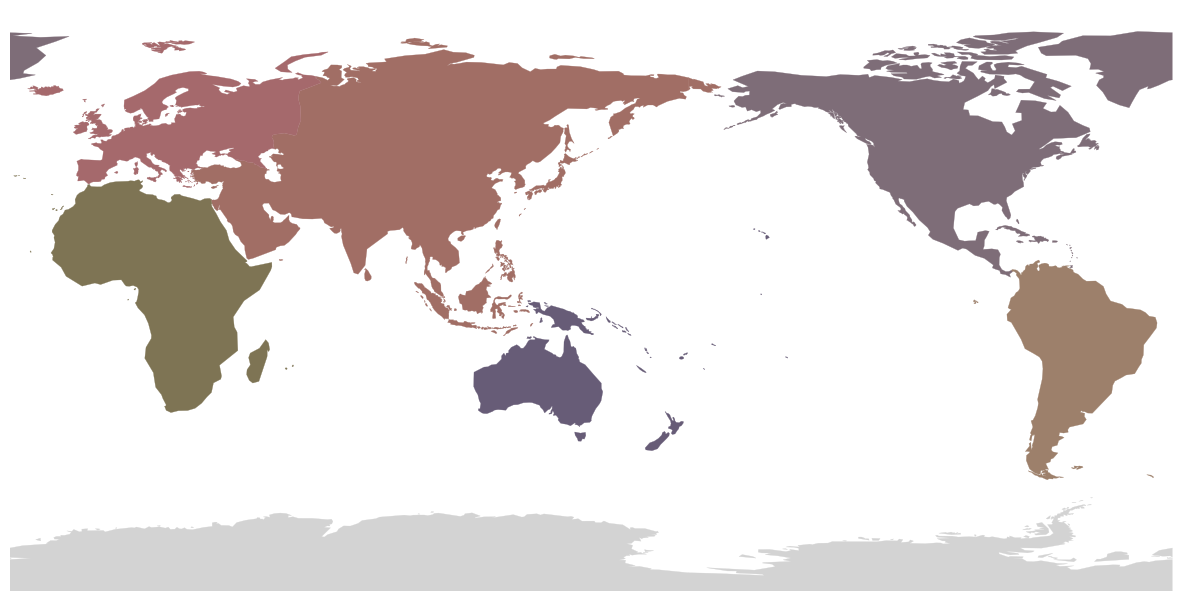

In [ ]:
# 七大洲地图 平均国旗颜色绘图
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='k', linewidth=0.1, transform=ccrs.PlateCarree())


# 读取地图数据
world = gpd.read_file('./kml2geojson/continent.geojson')
world = world.to_crs(ccrs.PlateCarree())
asia = world[world['name'].str.contains('亚洲', na=False)]
europe = world[world['name'].str.contains('欧洲', na=False)]
africa = world[world['name'].str.contains('非洲', na=False)]
ocean = world[world['name'].str.contains('大洋洲', na=False)]
northamerica = world[world['name'].str.contains('北美洲', na=False)]
southamerica = world[world['name'].str.contains('南美洲', na=False)]
antarctica = world[world['name'].str.contains('南极洲', na=False)]

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=150)})
# world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.OCEAN, color='white')
asia.plot(ax=ax, color='#a16e65', edgecolor='#a16e65', linewidth=0.2, transform=ccrs.PlateCarree())
europe.plot(ax=ax, color='#a5696c', edgecolor='#a5696c', linewidth=0.2, transform=ccrs.PlateCarree())
africa.plot(ax=ax, color='#7e7454', edgecolor='#7e7454', linewidth=0.2, transform=ccrs.PlateCarree())
ocean.plot(ax=ax, color='#675c77', edgecolor='#675c77', linewidth=0.2, transform=ccrs.PlateCarree())
northamerica.plot(ax=ax, color='#7e6d78', edgecolor='#7e6d78', linewidth=0.2, transform=ccrs.PlateCarree())
southamerica.plot(ax=ax, color='#9d806b', edgecolor='#9d806b', linewidth=0.2, transform=ccrs.PlateCarree())
antarctica.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', linewidth=0.2, transform=ccrs.PlateCarree())

# 保存图像并显示
ax.set_axis_off()
plt.savefig('flag.png', dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


最优点的纬度为 32.5093，经度为 113.3564


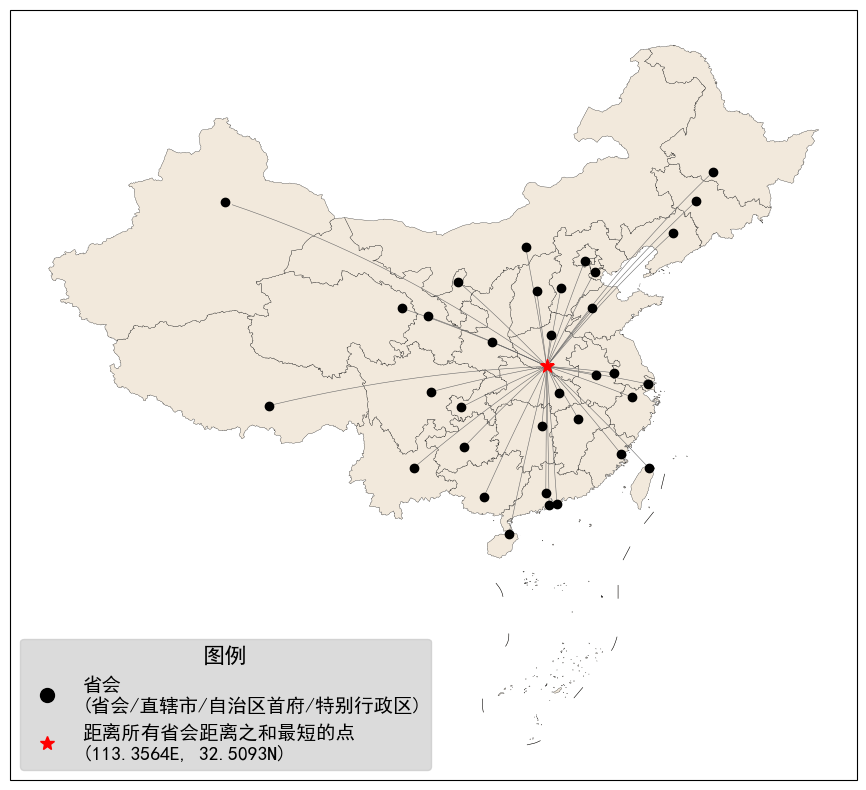

In [ ]:
# 中国中心-桐柏
# 计算距离所有省会距离之和最短的点，并绘图显示
import pandas as pd
import math
from scipy.optimize import minimize
from pyproj import Geod
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic
from matplotlib.lines import Line2D

df = pd.read_csv('./csv/province_capital.csv')
capitals = list(zip(df['Latitude'], df['Longitude']))
lats = list(df['Latitude'])
lons = list(df['Longitude'])


def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


def total_distance(point, capitals):
    lat, lon = point
    geod = Geod(ellps="WGS84")
    # print(sum(geod.line_length([lon,cap_lon], [lat,cap_lat]) for cap_lat, cap_lon in capitals))
    return sum(geod.line_length([lon,cap_lon], [lat,cap_lat]) for cap_lat, cap_lon in capitals)


def draw_line(ax, lon_list, lat_list, optimal_lon, optimal_lat):
    if len(lon_list) != len(lat_list):
        raise ValueError("经度列表和纬度列表的长度必须相等。")
    geod = Geod(ellps="WGS84")
    num_points = 50
    for lon, lat in zip(lon_list, lat_list):
        # 大地线
        point = geod.npts(lon, lat, optimal_lon, optimal_lat, num_points)
        lons, lats = zip(*point)
        ax.plot(lons, lats, color='dimgray', linewidth=0.4, transform=ccrs.Geodetic())
        # 平面直线
        # ax.plot([lon, optimal_lon], [lat, optimal_lat], color='dimgray', linewidth=0.4, transform=ccrs.PlateCarree(), zorder=4)

# 求最小值
initial_guess = (35, 105)
result = minimize(total_distance, initial_guess, args=(capitals,), method='L-BFGS-B', bounds=[(4, 53.5), (73.5, 134.7)])
optimal_lat, optimal_lon = result.x
print(f"最优点的纬度为 {optimal_lat:.4f}，经度为 {optimal_lon:.4f}")

# 绘图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

china = gpd.read_file('./chinamap/geo_china.json')
china = china.to_crs(ccrs.PlateCarree())
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})
china.plot(ax=ax, color='#F2E9DC', edgecolor='black', linewidth=0.2, transform=ccrs.PlateCarree())                           

draw_line(ax, lons, lats, optimal_lon, optimal_lat)
ax.scatter(lons, lats, color="k", marker='o', zorder=5, transform=ccrs.PlateCarree())
ax.scatter(optimal_lon, optimal_lat, color='red', edgecolors='red', marker='*', s=100, zorder=5, transform=ccrs.PlateCarree())

legend_elements = [
    Line2D([0], [0], marker='o', color='k', markerfacecolor='k', markersize=10, label='省会\n(省会/直辖市/自治区首府/特别行政区)', linestyle='None'),
    Line2D([0], [0], marker='*', color='red', markerfacecolor='red', markersize=10, label='距离所有省会距离之和最短的点\n(113.3564E, 32.5093N)', linestyle='None')
]
legend = ax.legend(handles=legend_elements, loc='lower left', title='图例', title_fontsize=16,prop={'size': 14})
legend.get_frame().set_facecolor('lightgray')

ax.tick_params(axis='both', which='both', length=0, labelsize=0)
plt.savefig('new_capital.png', dpi=1200, bbox_inches='tight')
plt.show()
